In [1]:
import os
import urllib.request
import tarfile
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from tqdm import tqdm
import glob


# Using LFW Dataset to test 

LFW Dataset: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

Deepface also used LFW Dataset for benchmarking their model accuracy-wise so here I am also using the same dataset for benchmarking

In [2]:
class LFWDatasetSetup:
    def __init__(self):
        self.base_dir = 'data/lfw'
        self.images_dir = 'data/lfw/lfw-deepfunneled'
            
    def scan_images(self):
        """Scan and catalog all images without creating artificial annotations"""
        if not os.path.exists(self.images_dir):
            print("❌ Images directory not found. Please extract dataset first.")
            return None
        
        print("🔍 Scanning images...")
        
        # Find all JPEG images
        image_paths = []
        for root, dirs, files in os.walk(self.images_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(root, file)
                    relative_path = os.path.relpath(full_path, self.images_dir)
                    image_paths.append(relative_path)
        
        print(f"✅ Found {len(image_paths)} images")
        
        image_dict = {img_path: [] for img_path in image_paths}
        
        return image_dict
    
    def visualize_samples(self, image_dict, num_samples=6):
        """Visualize sample images without bounding boxes"""
        if not image_dict:
            print("❌ No images to visualize")
            return
        
        sample_images = list(image_dict.keys())[:num_samples]
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, img_path in enumerate(sample_images):
            full_img_path = os.path.join(self.images_dir, img_path)
            
            if os.path.exists(full_img_path):
                img = cv2.imread(full_img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                axes[idx].imshow(img_rgb)
                axes[idx].set_title(f'Image {idx+1}')
                axes[idx].axis('off')
            else:
                axes[idx].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[idx].set_title('Missing')
        
        plt.suptitle('LFW Dataset Sample Images')
        plt.tight_layout()
        plt.show()
    
    def create_test_split(self, image_dict, test_ratio=0.2):
        """Split images into train and test sets"""
        image_paths = list(image_dict.keys())
        np.random.shuffle(image_paths)
        
        split_idx = int(len(image_paths) * (1 - test_ratio))
        train_paths = image_paths[:split_idx]
        test_paths = image_paths[split_idx:]
        
        train_dict = {path: [] for path in train_paths}
        test_dict = {path: [] for path in test_paths}
        
        print(f"📊 Dataset split:")
        print(f"  Training images: {len(train_dict)}")
        print(f"  Testing images: {len(test_dict)}")
        
        return train_dict, test_dict
    
    def get_dataset_statistics(self, image_dict):
        """Get basic dataset statistics"""
        if not image_dict:
            print("❌ No images to analyze")
            return
        
        total_images = len(image_dict)
        
        dimensions = []
        
        sample_images = list(image_dict.keys())[:100] 
        
        for img_path in sample_images:
            full_path = os.path.join(self.images_dir, img_path)
            if os.path.exists(full_path):
                img = cv2.imread(full_path)
                if img is not None:
                    h, w = img.shape[:2]
                    dimensions.append((w, h))
        
        print(f"\n📈 LFW Dataset Statistics:")
        print(f"  Total images: {total_images}")
        
        if dimensions:
            avg_w = np.mean([d[0] for d in dimensions])
            avg_h = np.mean([d[1] for d in dimensions])
            print(f"  Average image size: {avg_w:.0f} x {avg_h:.0f}")
    
    def setup_complete_dataset(self, visualize=False):
        """Complete setup process without adding artificial annotations"""
        print("🚀 Setting up LFW dataset for face detection testing...")
                        
        # Scan images
        image_dict = self.scan_images()
        if not image_dict:
            return None, None
        
        # Statistics
        self.get_dataset_statistics(image_dict)
        
        # Visualize samples
        if visualize:
            self.visualize_samples(image_dict)
        
        # Create train/test split
        train_dict, test_dict = self.create_test_split(image_dict)
        
        print("✅ LFW dataset setup complete!")
        print(f"📍 Images location: {self.images_dir}")
        
        return test_dict, self.images_dir

## Deepface Detector Class

In [5]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from deepface import DeepFace
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

class DeepFaceDetectorTest:
    def __init__(self, test_annotations, images_dir):
        self.test_annotations = test_annotations
        self.images_dir = images_dir
        
        self.detectors = ["opencv", "mtcnn", "retinaface", "ssd", "yunet", "centerface"]
        self.results = {}
    
    def test_single_detector(self, detector_name, max_images=50):
        print(f"\n🔍 Testing {detector_name} detector...")
        
        results = {
            'detector': detector_name,
            'total_images': 0,
            'successful_detections': 0,
            'detection_times': [],
            'faces_detected': [],
            'errors': 0,
            'confidences': [],     
            'embeddings': []     
        }
        
        test_images = list(self.test_annotations.keys())[:max_images]
        

        for idx, img_path in enumerate(test_images):
            if idx % 20 == 0:
                print(f"  Progress: {idx}/{len(test_images)} images processed")
            
            full_img_path = os.path.join(self.images_dir, img_path)
            
            if not os.path.exists(full_img_path):
                continue
                
            results['total_images'] += 1
            
            try:
                start_time = time.time()
                detections = DeepFace.extract_faces(
                    img_path=full_img_path,
                    detector_backend=detector_name,
                    enforce_detection=False,
                    align=False
                )
                detection_time = time.time() - start_time
                results['detection_times'].append(detection_time)

                # Only keep the face with the highest confidence (or first if no confidence)
                if detections:
                    confidences = [d.get("confidence") for d in detections]
                    if any(c is not None for c in confidences):
                        best = max(
                            detections,
                            key=lambda d: d.get("confidence") if d.get("confidence") is not None else float('-inf')
                        )
                    else:
                        best = detections[0]
                    results['faces_detected'].append(1)
                    results['confidences'].append(best.get("confidence", None))
                    # Get embedding for the best face
                    try:
                        embedding = DeepFace.represent(
                            img_path=full_img_path,
                            detector_backend=detector_name,
                            enforce_detection=False,
                            align=False
                        )
                        # Only store the first embedding if multiple returned
                        if isinstance(embedding, list) and len(embedding) > 0:
                            results['embeddings'].append(embedding[0]['embedding'])
                        else:
                            results['embeddings'].append(None)
                    except Exception:
                        results['embeddings'].append(None)
                else:
                    results['faces_detected'].append(0)
                    results['confidences'].append(None)
                    results['embeddings'].append(None)

                if len(detections) > 0:
                    results['successful_detections'] += 1
                    
            except Exception as e:
                results['errors'] += 1
        
        avg_time = np.mean(results['detection_times']) if results['detection_times'] else 0
        success_rate = results['successful_detections'] / results['total_images'] if results['total_images'] > 0 else 0
        avg_faces = np.mean(results['faces_detected']) if results['faces_detected'] else 0
        throughput = 1.0 / avg_time if avg_time > 0 else 0 
        
        results['avg_detection_time'] = avg_time
        results['success_rate'] = success_rate
        results['avg_faces_per_image'] = avg_faces
        results['throughput'] = throughput
        results['error_rate'] = results['errors'] / results['total_images'] if results['total_images'] > 0 else 0
        
        print(f"  ✅ {detector_name} completed:")
        print(f"    - Avg Detection Time: {avg_time:.3f}s")
        print(f"    - Throughput: {throughput:.2f} images/sec")
        print(f"    - Success Rate: {success_rate:.3f}")
        print(f"    - Error Rate: {results['error_rate']:.3f}")
        
        return results
    
    def test_all_detectors(self, max_images=50):
        """Test all detectors and collect results"""
        print("STARTING DEEPFACE DETECTOR PERFORMANCE TEST")
        print("="*60)
        print(f"🚀 Starting comprehensive detector testing...")
        print(f"📊 Testing on {min(max_images, len(self.test_annotations))} images")
        
        for detector in self.detectors:
            try:
                self.results[detector] = self.test_single_detector(detector, max_images)
            except Exception as e:
                print(f"❌ Failed to test {detector}: {e}")
                continue
        
        print("\n✅ All detector testing completed!")
        return self.results
    
    def create_performance_plots(self):
        """Create performance visualization focusing on speed and efficiency"""
        if not self.results:
            print("❌ No results to plot. Run test_all_detectors() first.")
            return
        
        detectors = list(self.results.keys())
        metrics_data = {
            'Detector': detectors,
            'Avg Detection Time (s)': [self.results[d]['avg_detection_time'] for d in detectors],
            'Throughput (img/sec)': [self.results[d]['throughput'] for d in detectors],
            'Success Rate': [self.results[d]['success_rate'] for d in detectors],
            'Error Rate': [self.results[d]['error_rate'] for d in detectors],
            'Avg Faces Detected': [self.results[d]['avg_faces_per_image'] for d in detectors],
        }
        
        
        # 1. Detection Speed (Bar chart)
        fig1 = go.Figure()
        fig1.add_trace(
            go.Bar(name='Avg Detection Time', x=detectors, 
                y=metrics_data['Avg Detection Time (s)'],
                marker_color='lightblue', text=metrics_data['Avg Detection Time (s)'],
                texttemplate='%{text:.3f}s', textposition='outside')
        )
        fig1.update_layout(
            title="Detection Speed Comparison",
            xaxis_title="Detector",
            yaxis_title="Time (seconds)",
            height=500,
            width=800
        )
        fig1.show()
        
        # 2. Throughput
        fig2 = go.Figure()
        fig2.add_trace(
            go.Bar(name='Throughput', x=detectors, 
                y=metrics_data['Throughput (img/sec)'],
                marker_color='lightgreen', text=metrics_data['Throughput (img/sec)'],
                texttemplate='%{text:.2f} img/s', textposition='outside')
        )
        fig2.update_layout(
            title="Throughput Comparison",
            xaxis_title="Detector",
            yaxis_title="Images per second",
            height=500,
            width=800
        )
        fig2.show()
        
        # 3. Success & Error Rates
        fig3 = go.Figure()
        fig3.add_trace(
            go.Bar(name='Success Rate', x=detectors, y=metrics_data['Success Rate'],
                marker_color='lightcoral', text=metrics_data['Success Rate'],
                texttemplate='%{text:.3f}', textposition='outside')
        )
        fig3.add_trace(
            go.Bar(name='Error Rate', x=detectors, y=metrics_data['Error Rate'],
                marker_color='gold', text=metrics_data['Error Rate'],
                texttemplate='%{text:.3f}', textposition='outside')
        )
        fig3.update_layout(
            title="Reliability Comparison",
            xaxis_title="Detector",
            yaxis_title="Rate",
            height=500,
            width=800,
            barmode='group',  
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
        fig3.show()
        
        # 4. Efficiency Scatter Plot - Throughput vs Success Rate
        fig4 = go.Figure()
        fig4.add_trace(
            go.Scatter(
                x=metrics_data['Throughput (img/sec)'],
                y=metrics_data['Success Rate'],
                mode='markers+text',
                text=detectors,
                textposition="top center",
                marker=dict(
                    size=15, 
                    color=metrics_data['Avg Detection Time (s)'],
                    colorscale='Viridis', 
                    showscale=True,
                    colorbar=dict(title="Detection Time (s)")
                ),
                name='Efficiency Plot',
            )
        )
        fig4.update_layout(
            title="Speed vs Reliability",
            xaxis_title="Throughput (images/sec)",
            yaxis_title="Success Rate",
            height=600,
            width=800
        )
        fig4.show()

        # 5. Confidence Score per Detector
        avg_confidences = []
        for d in detectors:
            confs = self.results[d]['confidences']
            avg = np.mean([c for c in confs if c is not None]) if confs else 0
            avg_confidences.append(avg)

        fig_conf = go.Figure()
        fig_conf.add_trace(
            go.Bar(
                name='Avg Confidence',
                x=detectors,
                y=avg_confidences,
                marker_color='mediumpurple',
                text=[f"{c:.3f}" if c is not None else "N/A" for c in avg_confidences],
                texttemplate='%{text}',
                textposition='outside'
            )
        )
        fig_conf.update_layout(
            title="Average Face Detection Confidence per Detector",
            xaxis_title="Detector",
            yaxis_title="Avg Confidence",
            height=500,
            width=800
        )
        fig_conf.show()

        
        self.create_detailed_table()    

    def create_detailed_table(self):
        if not self.results:
            return

        table_data = []
        for detector, result in self.results.items():
            avg_conf = (
                np.mean([c for c in result['confidences'] if c is not None])
                if result['confidences'] else None
            )
            table_data.append({
                'Detector': detector,
                'Total Images': result['total_images'],
                'Successful Detections': result['successful_detections'],
                'Avg Detection Time (s)': f"{result['avg_detection_time']:.3f}",
                'Throughput (img/sec)': f"{result['throughput']:.2f}",
                'Success Rate': f"{result['success_rate']:.3f}",
                'Error Rate': f"{result['error_rate']:.3f}",
                'Avg Faces Detected': f"{result['avg_faces_per_image']:.2f}",
                'Avg Confidence': f"{avg_conf:.3f}" if avg_conf is not None else "N/A",
                'Errors': result['errors']
            })

        df = pd.DataFrame(table_data)

        fig = go.Figure(data=[go.Table(
            header=dict(values=list(df.columns),
                    fill_color='paleturquoise',
                    align='left'),
            cells=dict(values=[df[col] for col in df.columns],
                    fill_color='lavender',
                    align='left'))
        ])

        fig.update_layout(
            title="DeepFace Detector Performance Comparison Table",
            height=400
        )

        fig.show()
        return df
    
    def get_best_detector(self):
        """Identify the best detector based on speed and efficiency"""
        if not self.results:
            print("❌ No results available")
            return
        
        print("\n🏆 Best Detector Analysis:")
        
        fastest = min(self.results.items(), key=lambda x: x[1]['avg_detection_time'])
        highest_throughput = max(self.results.items(), key=lambda x: x[1]['throughput'])
        most_reliable = max(self.results.items(), key=lambda x: x[1]['success_rate'])
        least_errors = min(self.results.items(), key=lambda x: x[1]['error_rate'])
        
        print(f"  ⚡ Fastest: {fastest[0]} ({fastest[1]['avg_detection_time']:.3f}s)")
        print(f"  🚀 Highest Throughput: {highest_throughput[0]} ({highest_throughput[1]['throughput']:.2f} img/sec)")
        print(f"  🎯 Most Reliable: {most_reliable[0]} ({most_reliable[1]['success_rate']:.3f})")
        print(f"  ✅ Least Errors: {least_errors[0]} ({least_errors[1]['error_rate']:.3f})")
        
        perfect_detectors = [d for d, r in self.results.items() 
                            if r['success_rate'] == 1.0 and r['error_rate'] == 0.0]
        
        if perfect_detectors:
            # If multiple detectors have perfect reliability, choose the fastest among them
            if len(perfect_detectors) > 1:
                best_perfect = min([(d, self.results[d]['avg_detection_time']) 
                                for d in perfect_detectors], key=lambda x: x[1])
                print(f"  🎖️ Multiple detectors have perfect reliability. Among them, fastest is: {best_perfect[0]} ({best_perfect[1]:.3f}s)")
                best_overall = best_perfect[0]
            else:
                best_overall = perfect_detectors[0]
                print(f"  🎖️ Perfect detector found: {best_overall} (perfect reliability with no errors)")
        else:
            # If no detector is perfect, use the balanced score
            balanced_scores = {}
            for detector, result in self.results.items():
                norm_speed = 1 / (1 + result['avg_detection_time'])  # Higher is better
                norm_success = result['success_rate']
                norm_error = 1 - result['error_rate']  
                
                balanced_scores[detector] = (norm_speed * 0.4 + norm_success * 0.4 + norm_error * 0.2)
            
            best_overall = max(balanced_scores.items(), key=lambda x: x[1])
            print(f"  🏆 Best Overall (Speed + Reliability): {best_overall[0]} (Score: {best_overall[1]:.3f})")
        
        return best_overall

Setting up LFW dataset...
🚀 Setting up LFW dataset for face detection testing...
🔍 Scanning images...
✅ Found 13233 images

📈 LFW Dataset Statistics:
  Total images: 13233
  Average image size: 250 x 250
📊 Dataset split:
  Training images: 10586
  Testing images: 2647
✅ LFW dataset setup complete!
📍 Images location: data/lfw/lfw-deepfunneled
🔍 Visualizing detector results on 5 sample images...


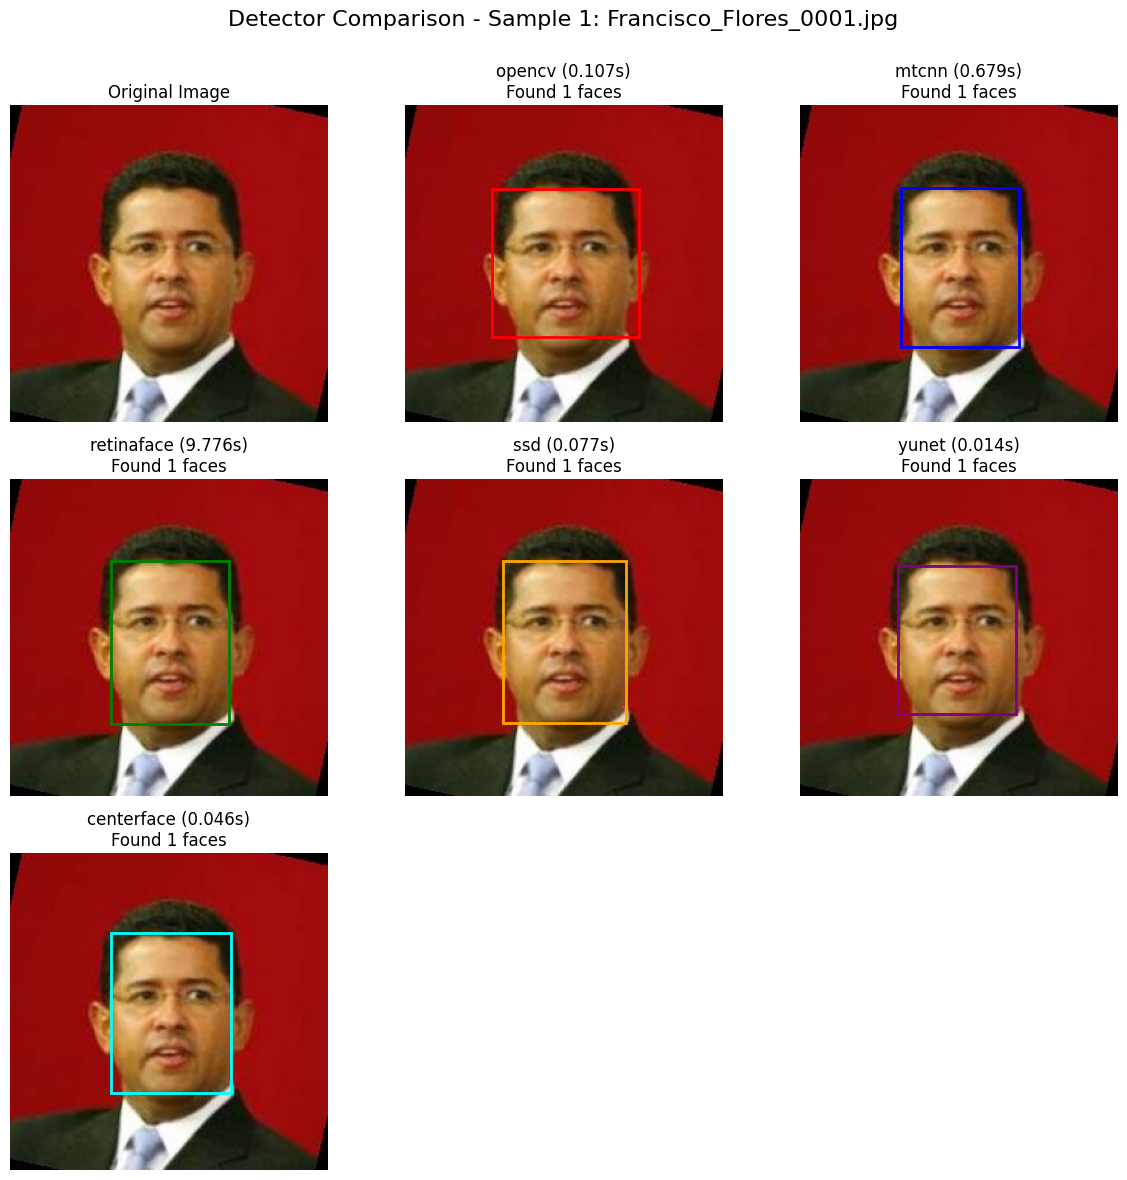

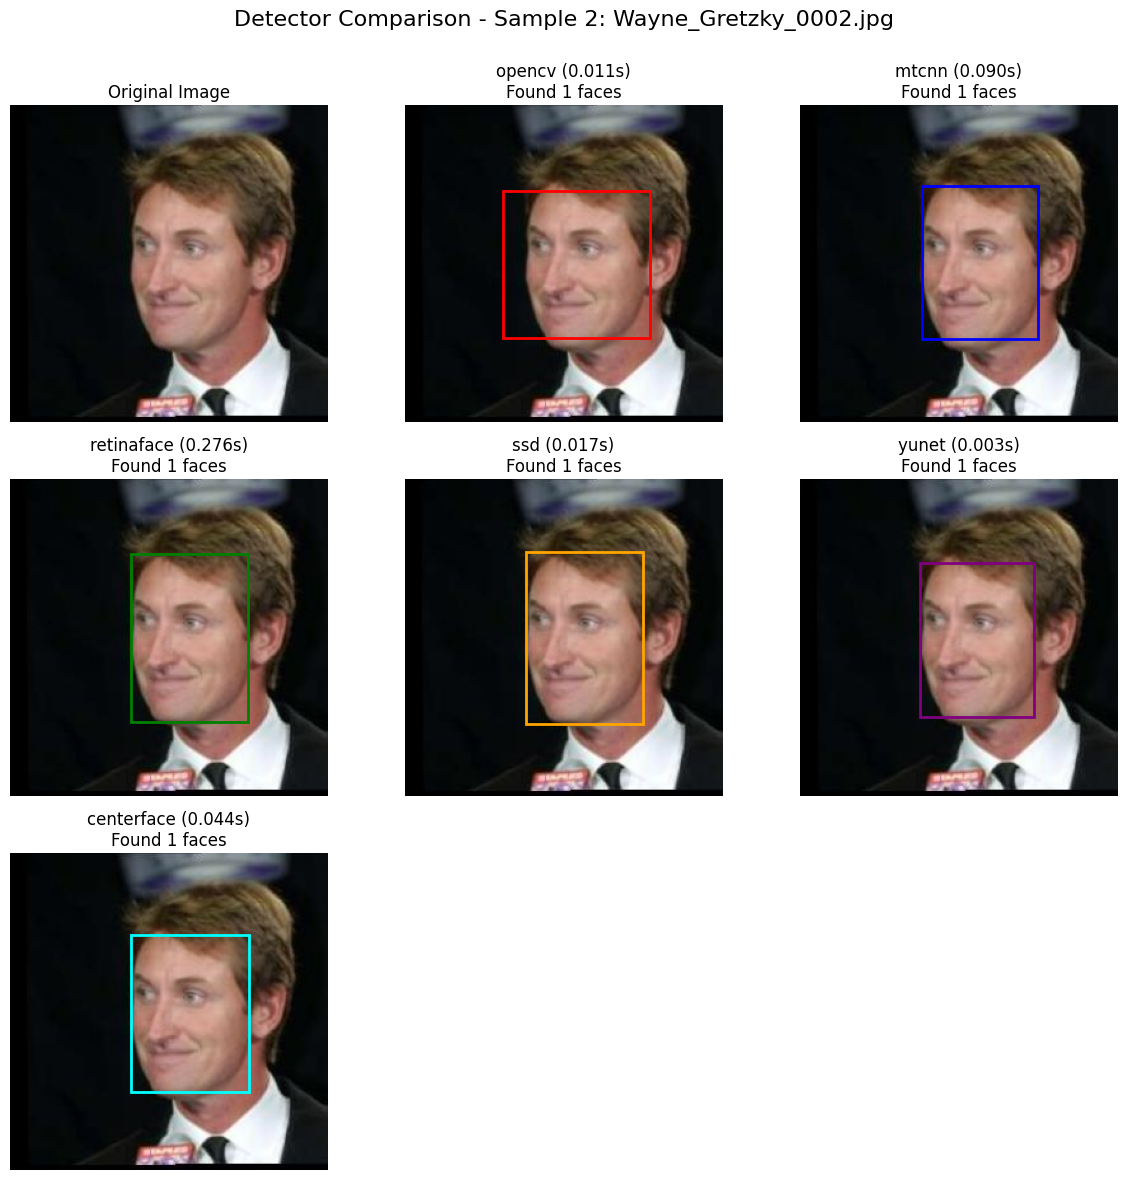

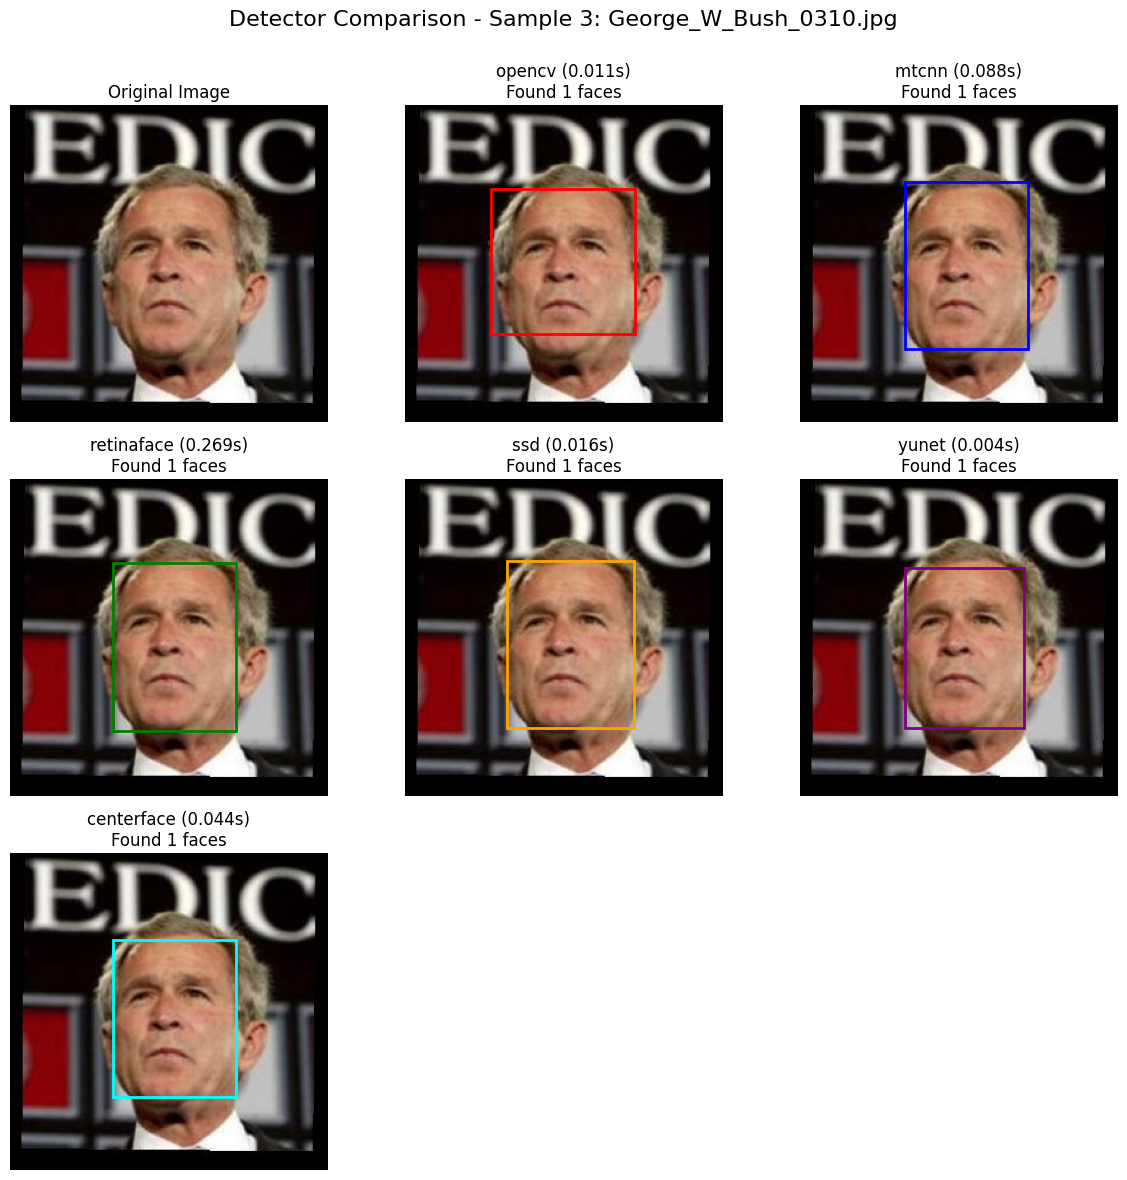

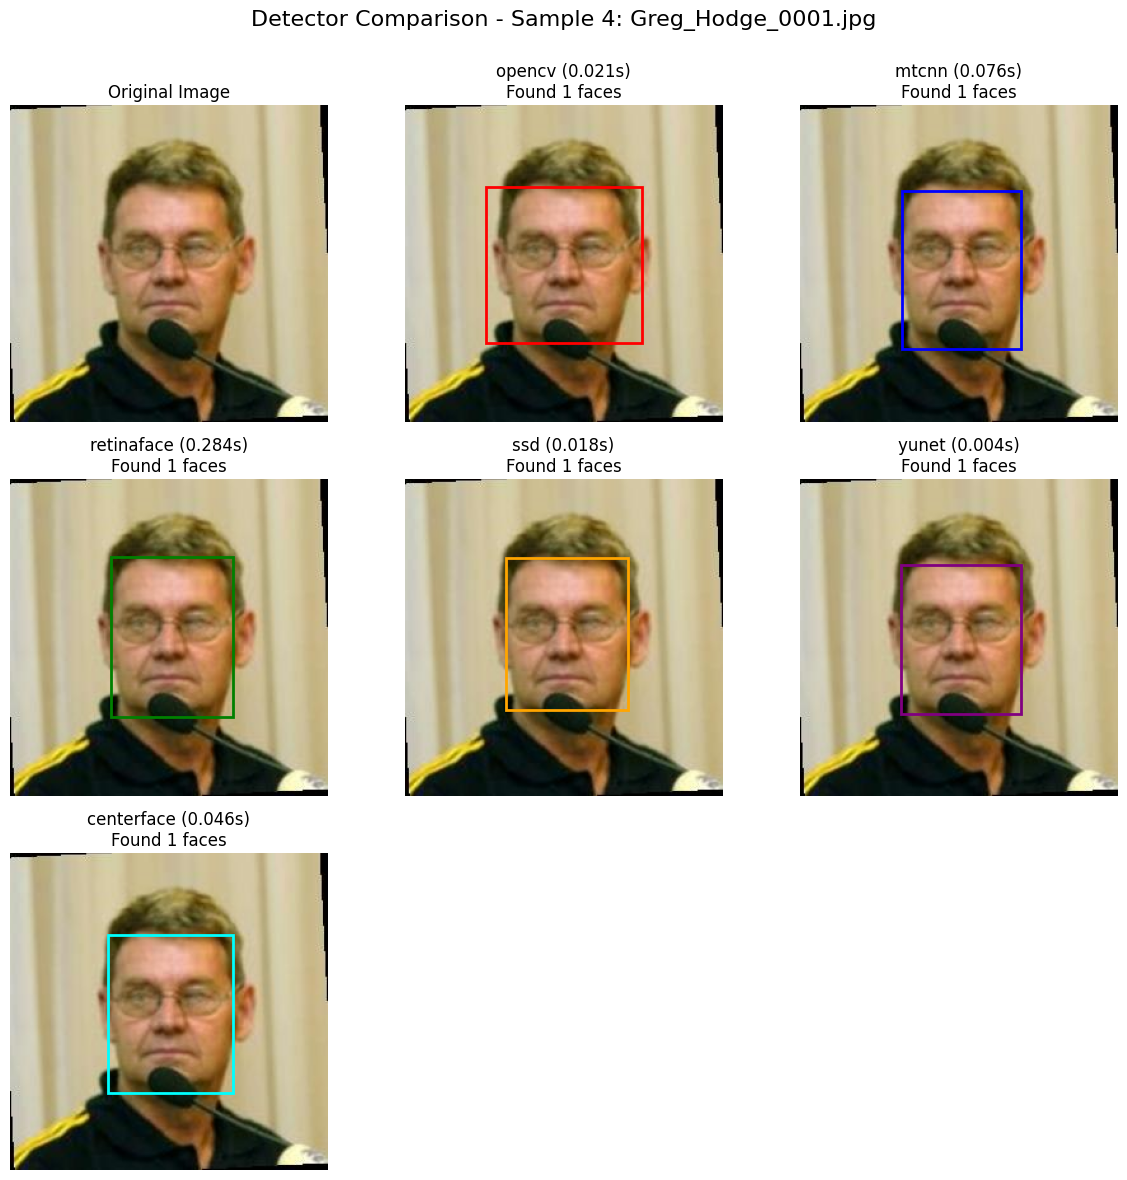

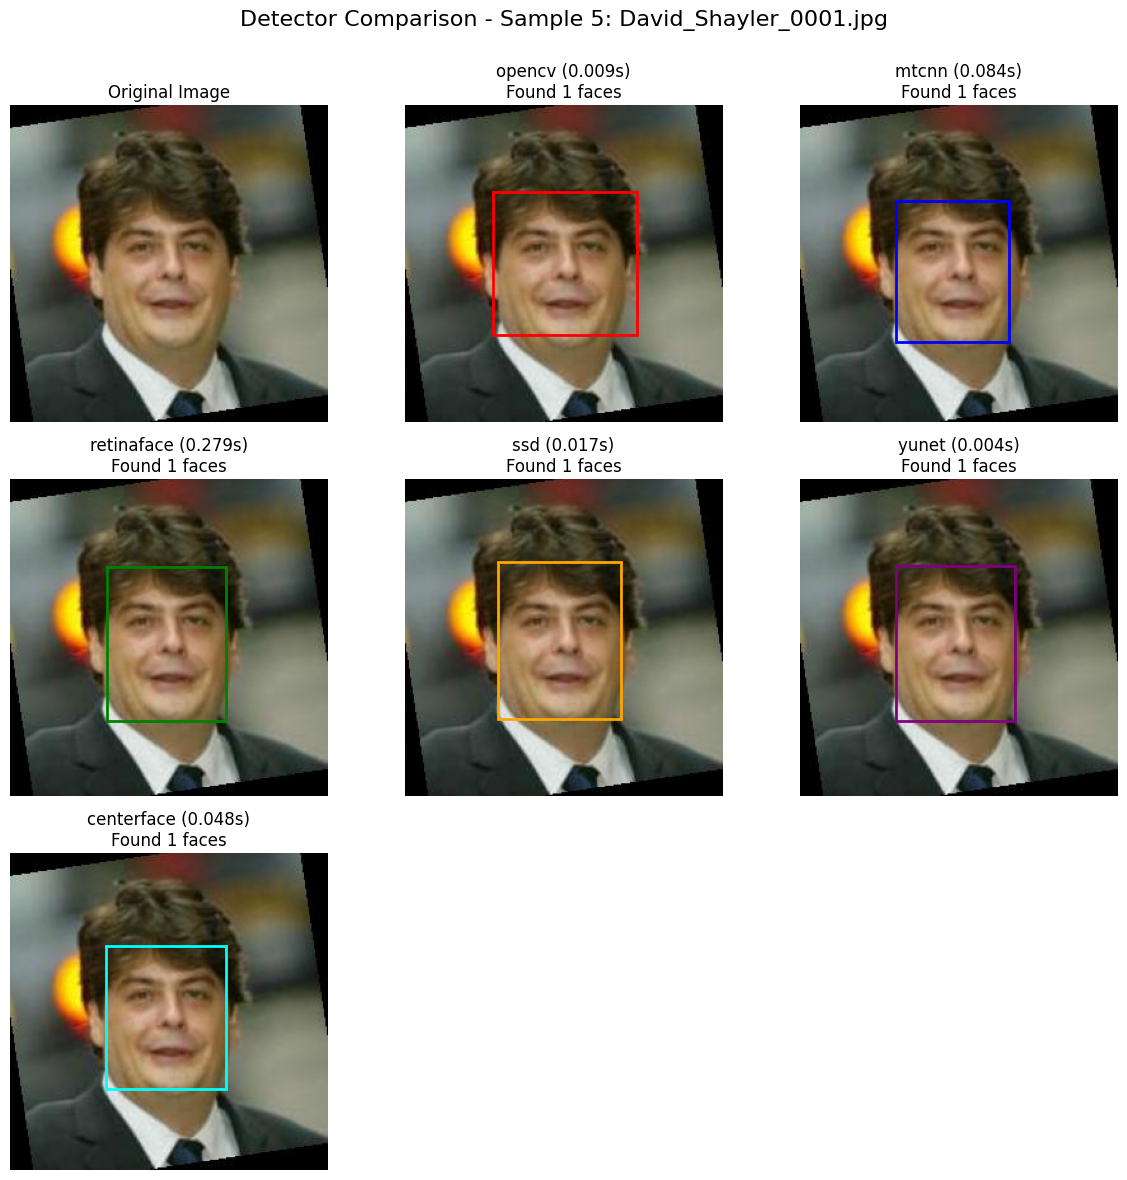

✅ Visualization complete!


({'John_Swofford/John_Swofford_0001.jpg': [],
  'Jean-David_Levitte/Jean-David_Levitte_0005.jpg': [],
  'Hector_Babenco/Hector_Babenco_0002.jpg': [],
  'Barbara_Walters/Barbara_Walters_0002.jpg': [],
  'Martin_Scorsese/Martin_Scorsese_0006.jpg': [],
  'Robin_Wright_Penn/Robin_Wright_Penn_0001.jpg': [],
  'Dan_Boyle/Dan_Boyle_0001.jpg': [],
  'Shane_Hmiel/Shane_Hmiel_0001.jpg': [],
  'Karen_Allen/Karen_Allen_0001.jpg': [],
  'Ruth_Bader_Ginsburg/Ruth_Bader_Ginsburg_0001.jpg': [],
  'Jon_Gruden/Jon_Gruden_0002.jpg': [],
  'Chen_Liang_Yu/Chen_Liang_Yu_0001.jpg': [],
  'Aparna_Pillai/Aparna_Pillai_0001.jpg': [],
  'Xanana_Gusmao/Xanana_Gusmao_0002.jpg': [],
  'Colin_Farrell/Colin_Farrell_0005.jpg': [],
  'Jessica_Alba/Jessica_Alba_0002.jpg': [],
  'Stefaan_Declerk/Stefaan_Declerk_0001.jpg': [],
  'Bill_McBride/Bill_McBride_0001.jpg': [],
  'Dick_Cheney/Dick_Cheney_0001.jpg': [],
  'Tung_Chee-hwa/Tung_Chee-hwa_0004.jpg': [],
  'Kevin_Millwood/Kevin_Millwood_0001.jpg': [],
  'Igor_Ivanov/Igo

In [6]:

def visualize_detector_bounding_boxes(test_annotations, images_dir, detectors=None, num_samples=3):
    """
    Visualize bounding boxes from different face detectors on sample images
    
    Args:
        test_annotations: Dictionary of test annotations (only used for image paths)
        images_dir: Path to images directory
        detectors: List of detector names (default: all available in DeepFace)
        num_samples: Number of sample images to visualize
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from deepface import DeepFace
    import random
    import time
    
    if detectors is None:
        detectors = ["opencv", "mtcnn", "retinaface", "ssd", "yunet", "centerface"]
    
    colors = {
        "opencv": "red",
        "mtcnn": "blue",
        "retinaface": "green",
        "ssd": "orange",
        "yunet": "purple",
        "centerface": "cyan",
    }
    
    # Randomly select sample images
    sample_keys = list(test_annotations.keys())
    if len(sample_keys) > num_samples:
        sample_keys = random.sample(sample_keys, num_samples)
    
    print(f"🔍 Visualizing detector results on {num_samples} sample images...")
    
    for idx, img_key in enumerate(sample_keys):
        full_img_path = os.path.join(images_dir, img_key)
        
        if not os.path.exists(full_img_path):
            print(f"Image not found: {full_img_path}")
            continue
        
        img = cv2.imread(full_img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        total_plots = len(detectors) + 1
        
        if total_plots <= 3:
            rows, cols = 1, total_plots
        elif total_plots <= 6:
            rows, cols = 2, 3
        else:
            rows, cols = 3, 3
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        fig.suptitle(f"Detector Comparison - Sample {idx+1}: {os.path.basename(img_key)}", fontsize=16)
        
        if rows == 1 and cols == 1:
            axes = np.array([axes])
        elif rows == 1 or cols == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        axes[0].imshow(img_rgb)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        for i, detector in enumerate(detectors):
            if i+1 >= len(axes):  
                break
                
            detector_img = img_rgb.copy()
            
            try:
                start_time = time.time()
                
                detections = DeepFace.extract_faces(
                    img_path=full_img_path,
                    detector_backend=detector,
                    enforce_detection=False,
                    align=False,
                )
                
                detection_time = time.time() - start_time
                
                # Display the image
                axes[i+1].imshow(detector_img)
                axes[i+1].set_title(f"{detector} ({detection_time:.3f}s)")
                
                # Draw bounding boxes for all detected faces
                if len(detections) > 0:
                    for detection in detections:
                        face_box = detection.get("facial_area", {})
                        if face_box:
                            x = face_box.get("x", 0)
                            y = face_box.get("y", 0)
                            w = face_box.get("w", 0)
                            h = face_box.get("h", 0)
                            
                            # Draw rectangle on the image
                            rect = patches.Rectangle(
                                (x, y), w, h, 
                                linewidth=2, 
                                edgecolor=colors[detector], 
                                facecolor="none"
                            )
                            axes[i+1].add_patch(rect)
                
                axes[i+1].set_title(f"{detector} ({detection_time:.3f}s)\nFound {len(detections)} faces")
                        
            except Exception as e:
                axes[i+1].text(0.5, 0.5, f"Error: {str(e)[:50]}...", 
                        ha='center', va='center', transform=axes[i+1].transAxes)
            
            axes[i+1].axis("off")
        
        for i in range(len(detectors) + 1, len(axes)):
            axes[i].axis('off')
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  
        plt.show()
        
    print("✅ Visualization complete!")

def compare_detector_outputs(num_samples=3):

    print("Setting up LFW dataset...")
    lfw_setup = LFWDatasetSetup()
    test_annotations, images_dir = lfw_setup.setup_complete_dataset()
    
    if test_annotations is None:
        print("❌ Failed to setup LFW dataset")
        return
        
    detectors = ["opencv", "mtcnn", "retinaface", "ssd", "yunet", "centerface"]
    
    visualize_detector_bounding_boxes(
        test_annotations=test_annotations,
        images_dir=images_dir,
        detectors=detectors,
        num_samples=num_samples
    )
    
    return test_annotations, images_dir

compare_detector_outputs(num_samples=5)

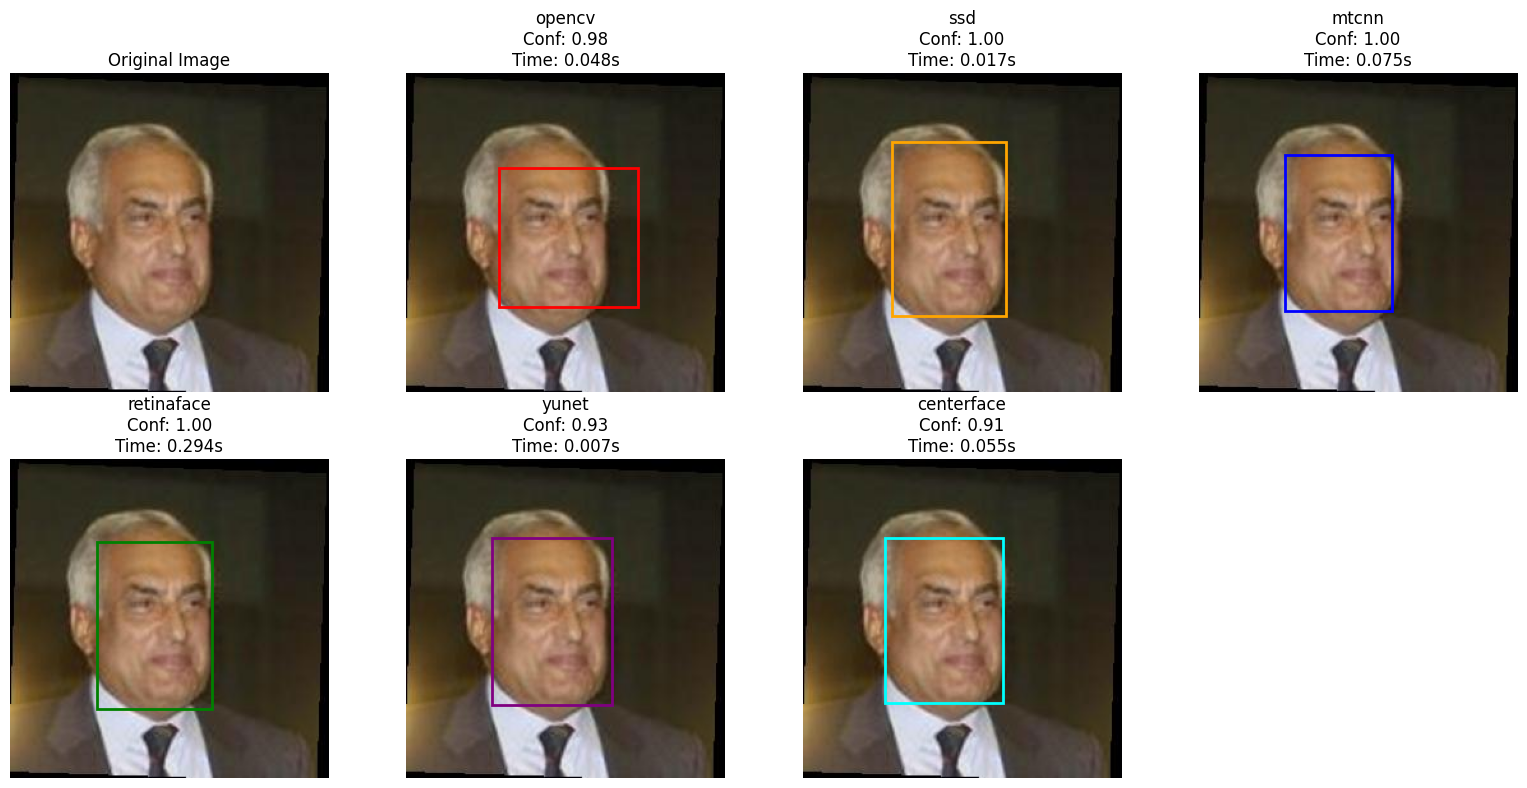

In [6]:
# Visualize only the most confident face detected by each detector for larry_lindsey_0002.jpg, including detection time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from deepface import DeepFace
import math
import cv2
import os
import time

detectors = [
    'opencv', 'ssd', 'mtcnn', 'retinaface', 'yunet', 'centerface'
]

colors = {
    "opencv": "red", "ssd": "orange", "mtcnn": "blue",
    "retinaface": "green", "yunet": "purple", "centerface": "cyan",
}

img_name = "Amer_al-Saadi_0003.jpg"
images_dir = "data/lfw/lfw-deepfunneled/Amer_al-Saadi"  
img_path = os.path.join(images_dir, img_name)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

total_plots = len(detectors) + 1
cols = 4
rows = math.ceil(total_plots / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, detector in enumerate(detectors):
    ax = axes[i+1]
    detector_img = img_rgb.copy()
    try:
        start_time = time.time()
        detections = DeepFace.extract_faces(
            img_path=img_path,
            detector_backend=detector,
            enforce_detection=False,
            align=False
        )
        detection_time = time.time() - start_time
        # Only keep the face with the highest confidence (or first if no confidence)
        if detections:
            confidences = [d.get("confidence") for d in detections]
            if any(c is not None for c in confidences):
                # At least one detection has confidence, pick the one with max confidence
                best = max(
                    detections,
                    key=lambda d: d.get("confidence") if d.get("confidence") is not None else float('-inf')
                )
            else:
                best = detections[0]
            faces_to_draw = [best]
        else:
            faces_to_draw = []
        
        ax.imshow(detector_img)
        for detection in faces_to_draw:
            face_box = detection.get("facial_area", {})
            if face_box:
                x = face_box.get("x", 0)
                y = face_box.get("y", 0)
                w = face_box.get("w", 0)
                h = face_box.get("h", 0)
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor=colors.get(detector, "yellow"),
                    facecolor="none"
                )
                ax.add_patch(rect)
        conf = faces_to_draw[0].get("confidence", None) if faces_to_draw else None
        if conf is not None:
            ax.set_title(f"{detector}\nConf: {conf:.2f}\nTime: {detection_time:.3f}s")
        else:
            ax.set_title(f"{detector}\nNo confidence\nTime: {detection_time:.3f}s")
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)[:50]}...", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(detector)
    ax.axis("off")

for i in range(len(detectors)+1, len(axes)):
    axes[i].axis('off')
    axes[i].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Setting up LFW dataset...
🚀 Setting up LFW dataset for face detection testing...
🔍 Scanning images...
✅ Found 13233 images

📈 LFW Dataset Statistics:
  Total images: 13233
  Average image size: 250 x 250


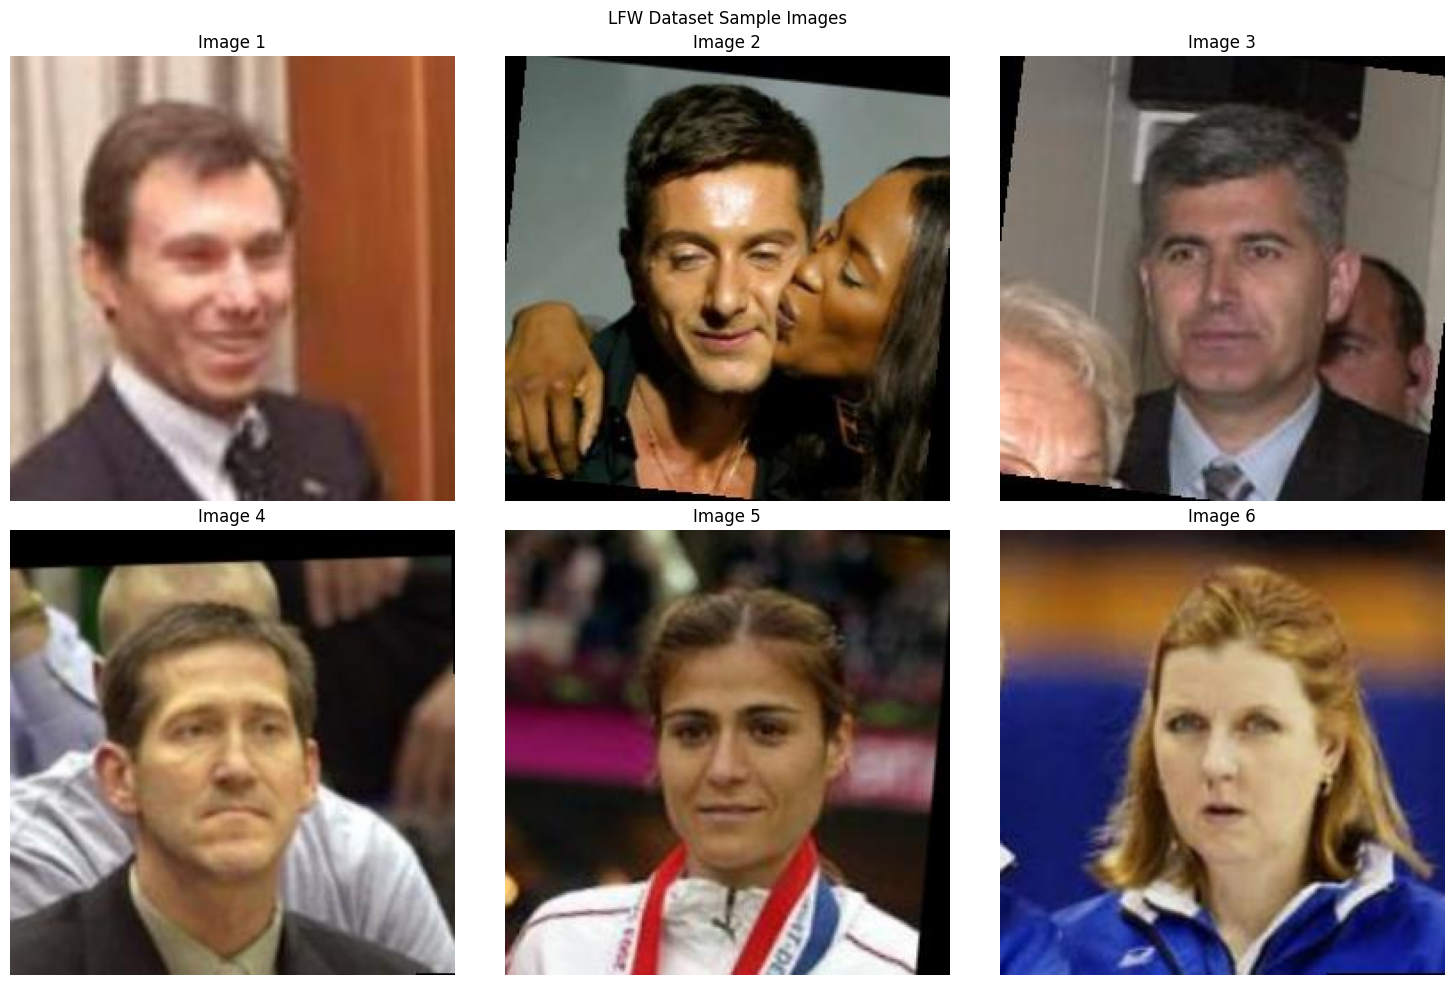

📊 Dataset split:
  Training images: 10586
  Testing images: 2647
✅ LFW dataset setup complete!
📍 Images location: data/lfw/lfw-deepfunneled

STARTING DEEPFACE DETECTOR PERFORMANCE TEST
STARTING DEEPFACE DETECTOR PERFORMANCE TEST
🚀 Starting comprehensive detector testing...
📊 Testing on 1024 images

🔍 Testing opencv detector...
  Progress: 0/1024 images processed
  Progress: 20/1024 images processed
  Progress: 40/1024 images processed
  Progress: 60/1024 images processed
  Progress: 80/1024 images processed
  Progress: 100/1024 images processed
  Progress: 120/1024 images processed
  Progress: 140/1024 images processed
  Progress: 160/1024 images processed
  Progress: 180/1024 images processed
  Progress: 200/1024 images processed
  Progress: 220/1024 images processed
  Progress: 240/1024 images processed
  Progress: 260/1024 images processed
  Progress: 280/1024 images processed
  Progress: 300/1024 images processed
  Progress: 320/1024 images processed
  Progress: 340/1024 images pro


🏆 Best Detector Analysis:
  ⚡ Fastest: yunet (0.008s)
  🚀 Highest Throughput: yunet (119.32 img/sec)
  🎯 Most Reliable: opencv (1.000)
  ✅ Least Errors: opencv (0.000)
  🎖️ Multiple detectors have perfect reliability. Among them, fastest is: yunet (0.008s)


In [8]:
def run_deepface_test():
    print("Setting up LFW dataset...")
    lfw_setup = LFWDatasetSetup()
    test_annotations, images_dir = lfw_setup.setup_complete_dataset(visualize=True)
    
    if test_annotations is None:
        print("❌ Failed to setup LFW dataset")
        return
    
    print("\n" + "="*60)
    print("STARTING DEEPFACE DETECTOR PERFORMANCE TEST")
    print("="*60)
    
    detector_test = DeepFaceDetectorTest(test_annotations, images_dir)
    
    results = detector_test.test_all_detectors(max_images=1024)
    
    detector_test.create_performance_plots()
    
    detector_test.get_best_detector()
    
    return detector_test

test_instance = run_deepface_test()

## Testing performance of face recognition models

For qualitative evaluation (visual/manual inspection, quick similarity checks), which i want a small subset

### Qualitative:

- 5–10 people
- 3–5 images per person

### Quantitative:

50–200 people
3–10 images per person



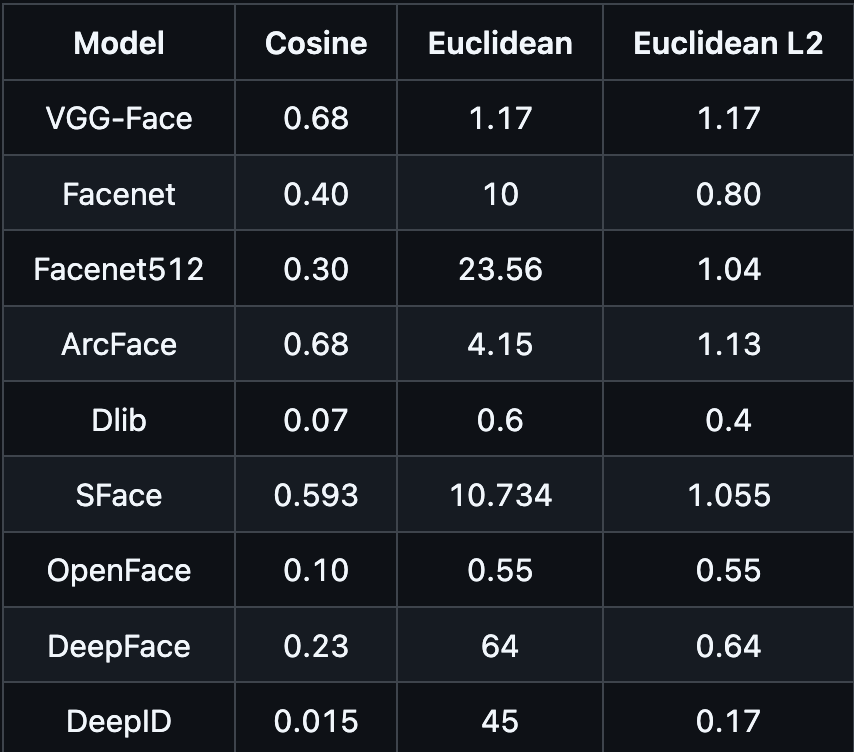

In [11]:
import os
import random
from collections import defaultdict

def select_lfw_subset(images_dir, num_people=10, images_per_person=5):
    random.seed()
    people = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
    person_to_imgs = defaultdict(list)
    for person in people:
        person_dir = os.path.join(images_dir, person)
        imgs = [os.path.join(person_dir, f) for f in os.listdir(person_dir) if f.lower().endswith('.jpg')]
        if len(imgs) >= images_per_person:
            person_to_imgs[person] = imgs
    # Filter people with enough images
    eligible_people = [p for p in person_to_imgs if len(person_to_imgs[p]) >= images_per_person]
    selected_people = random.sample(eligible_people, min(num_people, len(eligible_people)))
    subset = {p: random.sample(person_to_imgs[p], images_per_person) for p in selected_people}
    print(f"Selected {len(subset)} people, {images_per_person} images each (total {len(subset)*images_per_person} images)")
    print("Example people:", list(subset.keys()))
    return subset

lfw_dir = "data/lfw/lfw-deepfunneled"
qual_subset = select_lfw_subset(lfw_dir, num_people=10, images_per_person=3)
quant_subset = select_lfw_subset(lfw_dir, num_people=400, images_per_person=3)

Selected 10 people, 3 images each (total 30 images)
Example people: ['Katherine_Harris', 'Mitchell_Daniels', 'Paul_Sarbanes', 'Carlos_Ruiz', 'Matthew_Broderick', 'Monica_Bellucci', 'Milo_Djukanovic', 'Placido_Domingo', 'Clint_Eastwood', 'Bob_Huggins']
Selected 400 people, 3 images each (total 1200 images)
Example people: ['Jim_Tressel', 'Mikhail_Youzhny', 'Tom_Reilly', 'Aleksander_Kwasniewski', 'Jennifer_Garner', 'Katie_Harman', 'Aicha_El_Ouafi', 'Kalpana_Chawla', 'Adrien_Brody', 'Hu_Jintao', 'Kelly_Clarkson', 'Vojislav_Kostunica', 'John_Mayer', 'Donald_Pettit', 'Filippo_Inzaghi', 'LeBron_James', 'Don_Siegelman', 'Luis_Ernesto_Derbez_Bautista', 'Hugo_Chavez', 'Michelle_Kwan', 'Cruz_Bustamante', 'Prince_Willem-Alexander', 'Kathleen_Kennedy_Townsend', 'Patricia_Clarkson', 'Xavier_Malisse', 'George_Robertson', 'Jeremy_Greenstock', 'Bulent_Ecevit', 'Maria_Soledad_Alvear_Valenzuela', 'Catherine_Zeta-Jones', 'Norah_Jones', 'Tommy_Thompson', 'William_Donaldson', 'Richard_Krajicek', 'Debbie_Re

Selected 30 people, 3 images each (total 90 images)
Example people: ['Jackie_Chan', 'Edmund_Hillary', 'Antonio_Banderas', 'Martina_McBride', 'Dan_Morales', 'Luciano_Pavarotti', 'Kristanna_Loken', 'George_Voinovich', 'Candice_Bergen', 'Dominique_de_Villepin', 'Norm_Coleman', 'Javier_Weber', 'Muhammad_Saeed_al-Sahhaf', 'Gwyneth_Paltrow', 'Ken_Macha', 'Alexander_Downer', 'Yevgeny_Kafelnikov', 'Rachel_Hunter', 'Jerry_Springer', 'Mike_Myers', 'Keith_Bogans', 'Naoto_Kan', 'Nelson_Mandela', 'Angela_Bassett', 'Eric_Robert_Rudolph', 'Thomas_OBrien', 'Hans_Eichel', 'Heather_Mills', 'Paul_Martin', 'Valentino_Rossi']
Visualizing results for: Jackie_Chan
Image: data/lfw/lfw-deepfunneled/Jackie_Chan/Jackie_Chan_0011.jpg
Setting up qualitative evaluation...
Gallery: 30 people, 2 images each
Test: 3 people (1 unknown)
Gallery people: ['John_Bolton', 'Jim_Carrey', 'Hipolito_Mejia', 'Dale_Earnhardt_Jr', 'Jerry_Springer']...
Test people: ['Thomas_OBrien', 'Sam_Bith', 'Ben_Curtis']

Test images:
  Thomas_

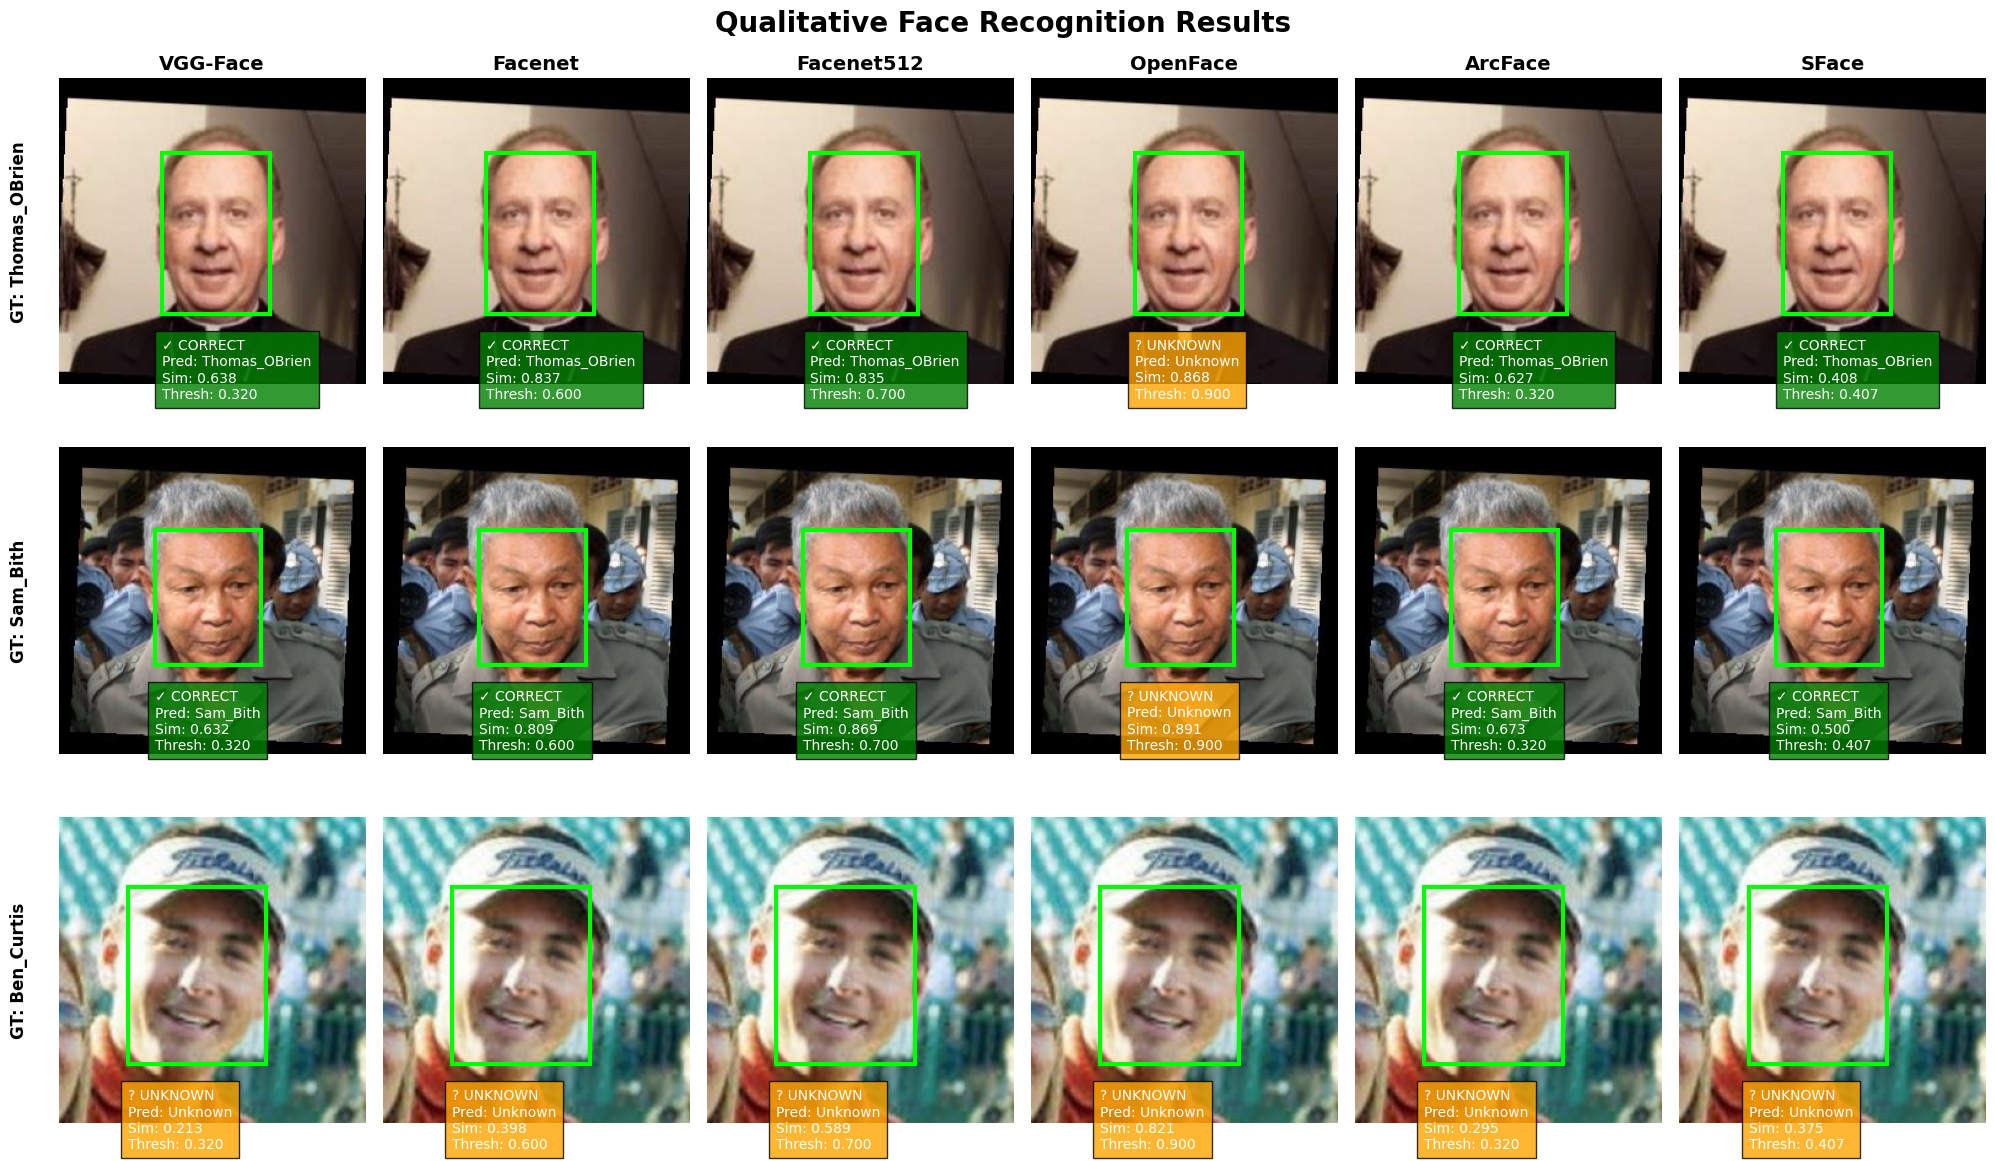

In [22]:
import numpy as np
import pandas as pd
from deepface import DeepFace
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import random
from collections import defaultdict

# DeepFace models to evaluate
deepface_models = [
    "VGG-Face", 
    "Facenet", 
    "Facenet512", 
    "OpenFace", 
    "ArcFace", 
    "SFace"
]

# Cosine similarity thresholds (converted from distance thresholds)
cosine_similarity_thresholds = {
    "VGG-Face": 1 - 0.68,      # 0.32
    "Facenet": 1 - 0.40,       # 0.60
    "Facenet512": 1 - 0.30,    # 0.70
    "OpenFace": 1 - 0.10,      # 0.90
    "ArcFace": 1 - 0.68,       # 0.32
    "SFace": 1 - 0.593,        # 0.407
}

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def get_person_label_from_path(img_path):
    """Extract person label from image path."""
    return os.path.basename(os.path.dirname(img_path))

def select_lfw_qualitative_data(
    images_dir, num_gallery_people=30, images_per_person=2, 
    num_test_people=2, num_unknown_people=0, seed=42
):
    random.seed(seed)




    
    people = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
    person_to_imgs = defaultdict(list)
    for person in people:
        person_dir = os.path.join(images_dir, person)
        imgs = [os.path.join(person_dir, f) for f in os.listdir(person_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(imgs) >= images_per_person + 1:
            person_to_imgs[person] = imgs

    eligible_people = [p for p in person_to_imgs if len(person_to_imgs[p]) >= images_per_person + 1]
    selected_gallery_people = random.sample(eligible_people, min(num_gallery_people, len(eligible_people)))
    gallery_subset = {person: random.sample(person_to_imgs[person], images_per_person) for person in selected_gallery_people}

    # Test people from gallery
    test_people = random.sample(selected_gallery_people, num_test_people)
    test_data = {}
    for person in test_people:
        available_imgs = [img for img in person_to_imgs[person] if img not in gallery_subset[person]]
        if available_imgs:
            test_data[person] = random.choice(available_imgs)
        else:
            test_data[person] = random.choice(gallery_subset[person])

    # Add unknown people (not in gallery)
    if num_unknown_people > 0:
        unknown_candidates = [p for p in eligible_people if p not in selected_gallery_people]
        unknown_people = random.sample(unknown_candidates, min(num_unknown_people, len(unknown_candidates)))
        for person in unknown_people:
            test_data[person] = random.choice(person_to_imgs[person])

    print(f"Gallery: {len(gallery_subset)} people, {images_per_person} images each")
    print(f"Test: {len(test_data)} people ({num_unknown_people} unknown)")
    print(f"Gallery people: {list(gallery_subset.keys())[:5]}...")
    print(f"Test people: {list(test_data.keys())}")
    return gallery_subset, test_data

def extract_embeddings_safely(img_path, model_name):
    """Safely extract embeddings from an image."""
    try:
        reps = DeepFace.represent(
            img_path=img_path, 
            model_name=model_name, 
            enforce_detection=False, 
            detector_backend="yunet"
        )
        if isinstance(reps, list) and len(reps) > 0:
            return reps[0]['embedding']
    except Exception as e:
        print(f"Failed to extract embedding from {img_path}: {e}")
    return None

def find_best_match(query_embedding, gallery_embeddings, threshold):
    """Find the best matching person in the gallery."""
    best_similarity = -1
    best_person = None
    
    for person, embedding in gallery_embeddings:
        similarity = cosine_similarity(query_embedding, embedding)
        if similarity > best_similarity:
            best_similarity = similarity
            best_person = person
    
    # Apply threshold
    if best_similarity < threshold:
        best_person = "Unknown"
    
    return best_person, best_similarity

def visualize_qualitative_results(gallery_subset, test_data, models=None, figsize=(20, 12)):
    """
    Visualize recognition results for all test people across all models.
    """
    if models is None:
        models = deepface_models
    
    test_people = list(test_data.keys())
    n_test_people = len(test_people)
    n_models = len(models)
    
    # Create figure with subplots: rows = test_people, cols = models
    fig, axes = plt.subplots(n_test_people, n_models, figsize=figsize)
    
    # Handle case where we have only 1 test person or 1 model
    if n_test_people == 1:
        axes = axes.reshape(1, -1)
    if n_models == 1:
        axes = axes.reshape(-1, 1)
    if n_test_people == 1 and n_models == 1:
        axes = np.array([[axes]])
    
    fig.suptitle('Qualitative Face Recognition Results', fontsize=20, fontweight='bold')
    
    for person_idx, person in enumerate(test_people):
        test_img_path = test_data[person]
        gt_label = person
        
        # Load and process image
        img = cv2.imread(test_img_path)
        if img is None:
            print(f"Could not load image: {test_img_path}")
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect faces
        try:
            dets = DeepFace.extract_faces(
                img_path=test_img_path, 
                detector_backend="yunet", 
                enforce_detection=False
            )
            if not dets:
                print(f"No face detected in {test_img_path}")
                continue
            
            face_box = dets[0].get("facial_area", {})
            if not face_box:
                print(f"No bounding box found in {test_img_path}")
                continue
        except Exception as e:
            print(f"Face detection failed for {test_img_path}: {e}")
            continue
        
        x, y, w, h = face_box.get("x", 0), face_box.get("y", 0), face_box.get("w", 0), face_box.get("h", 0)
        
        # Process each model
        for model_idx, model in enumerate(models):
            ax = axes[person_idx, model_idx] if n_test_people > 1 else axes[model_idx]
            
            # Display image
            ax.imshow(img_rgb)
            ax.axis("off")
            
            # Add bounding box
            rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor="lime", facecolor="none")
            ax.add_patch(rect)
            
            try:
                # Get query embedding
                query_embedding = extract_embeddings_safely(test_img_path, model)
                if query_embedding is None:
                    raise Exception("Failed to extract embedding")
                
                # Build gallery embeddings
                gallery_embeddings = []
                for gallery_person, img_list in gallery_subset.items():
                    for img in img_list:
                        embedding = extract_embeddings_safely(img, model)
                        if embedding is not None:
                            gallery_embeddings.append((gallery_person, embedding))
                
                if not gallery_embeddings:
                    raise Exception("No gallery embeddings available")
                
                # Find best match
                threshold = cosine_similarity_thresholds.get(model, 0.5)
                pred_label, best_similarity = find_best_match(query_embedding, gallery_embeddings, threshold)
                
                # Determine result color and status
                if pred_label == gt_label:
                    bbox_color = 'green'
                    result_text = "✓ CORRECT"
                elif pred_label == "Unknown":
                    bbox_color = 'orange'
                    result_text = "? UNKNOWN"
                else:
                    bbox_color = 'red'
                    result_text = "✗ INCORRECT"
                
                # Create label text
                label_text = (f"{result_text}\n"
                             f"Pred: {pred_label}\n"
                             f"Sim: {best_similarity:.3f}\n"
                             f"Thresh: {threshold:.3f}")
                
            except Exception as e:
                bbox_color = 'red'
                label_text = f"ERROR\n{str(e)[:20]}..."
            
            # Add text box
            ax.text(x, y + h + 20, label_text, color="white", fontsize=10,
                    bbox=dict(facecolor=bbox_color, alpha=0.8, pad=5),
                    verticalalignment='top')
            
            # Set titles
            if person_idx == 0:  # Only set model titles on first row
                ax.set_title(f"{model}", fontsize=14, fontweight='bold')
            
        # Add person label on the left
        if n_test_people > 1:
            axes[person_idx, 0].text(-0.1, 0.5, f"GT: {person}", 
                                   transform=axes[person_idx, 0].transAxes,
                                   rotation=90, fontsize=12, fontweight='bold',
                                   verticalalignment='center', horizontalalignment='right')
        else:
            axes[0].text(-0.1, 0.5, f"GT: {person}", 
                        transform=axes[0].transAxes,
                        rotation=90, fontsize=12, fontweight='bold',
                        verticalalignment='center', horizontalalignment='right')
    
    plt.tight_layout()
    plt.show()

def run_qualitative_evaluation(lfw_dir, num_gallery_people=30, images_per_person=2, 
                             num_test_people=2, models=None, seed=42):
    """
    Complete qualitative evaluation pipeline.
    """
    print("Setting up qualitative evaluation...")
    print("=" * 50)
    
    gallery_subset, test_data = select_lfw_qualitative_data(
        lfw_dir,
        num_gallery_people=30,
        images_per_person=2,
        num_test_people=2,         # 2 known people (from gallery)
        num_unknown_people=1,      # 1 unknown person (not in gallery)
        seed=42
    )    
    print(f"\nTest images:")
    for person, img_path in test_data.items():
        print(f"  {person}: {os.path.basename(img_path)}")
    
    # Visualize results
    print(f"\nVisualizing results for {len(test_data)} test people...")
    visualize_qualitative_results(gallery_subset, test_data, models)
    
    return gallery_subset, test_data


if __name__ == "__main__":
    lfw_dir = "data/lfw/lfw-deepfunneled"
    qual_subset = select_lfw_subset(lfw_dir, num_people=30, images_per_person=3)
    
    first_person = next(iter(qual_subset))
    first_img = qual_subset[first_person][0]
    
    print(f"Visualizing results for: {first_person}")
    print(f"Image: {first_img}")
    
    run_qualitative_evaluation(lfw_dir, models=deepface_models)


# quantitative evaluation

## generating dataset, 420 people, 3 images per person for a test_db

In [44]:
import os
import random
import shutil
import json

def generate_face_database(
    lfw_dir, 
    num_people=420, 
    images_per_person=3
):
    script_base_dir = os.getcwd()
    
    test_data_base_dir = os.path.join(script_base_dir, "test_data")

    image_output_dir = os.path.join(test_data_base_dir, "database")
    
    os.makedirs(image_output_dir, exist_ok=True)
    print(f"Ensuring image output directory exists: {os.path.abspath(image_output_dir)}")
    
    all_people = [
        d for d in os.listdir(lfw_dir) 
        if os.path.isdir(os.path.join(lfw_dir, d))
    ]
    
    eligible_people = []
    for person in all_people:
        person_dir = os.path.join(lfw_dir, person)
        images = [
            f for f in os.listdir(person_dir) 
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        if len(images) >= images_per_person:
            eligible_people.append((person, images))
    
    a_people = [p for p in eligible_people if p[0].startswith("A")]
    other_people = [p for p in eligible_people if not p[0].startswith("A")]
    
    selected_people = a_people + other_people
    selected_people = selected_people[:num_people]
    
    used_people_names = []
    total_images = 0
    
    print(f"Clearing existing image files in {os.path.abspath(image_output_dir)}...")
    for f in os.listdir(image_output_dir):
        file_path = os.path.join(image_output_dir, f)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    print("Finished clearing image files.")

    for person, images in selected_people:
        person_dir = os.path.join(lfw_dir, person)
        chosen_images = sorted(images)[:images_per_person]
        
        for img_name in chosen_images:
            src = os.path.join(person_dir, img_name)
            dst = os.path.join(image_output_dir, img_name) 
            shutil.copy2(src, dst)
            total_images += 1
        
        used_people_names.append(person)
    
    print(f"✅ Database created with {len(used_people_names)} people and {total_images} images.")
    
    people_list_path = os.path.join(test_data_base_dir, "people_in_database.json")
    print(f"Attempting to save JSON to: {os.path.abspath(people_list_path)}")
    try:
        with open(people_list_path, "w") as f:
            json.dump(used_people_names, f, indent=2)
        print(f"📝 Successfully saved person names to: {os.path.abspath(people_list_path)}")
    except Exception as e:
        print(f"❌ Error saving JSON file: {e}")
    
    return used_people_names

generate_face_database("data/lfw/lfw-deepfunneled")

Ensuring image output directory exists: /Users/ritherthemuncher/Desktop/server_facereg/test_data/database
Clearing existing image files in /Users/ritherthemuncher/Desktop/server_facereg/test_data/database...
Finished clearing image files.
✅ Database created with 420 people and 1260 images.
Attempting to save JSON to: /Users/ritherthemuncher/Desktop/server_facereg/test_data/people_in_database.json
📝 Successfully saved person names to: /Users/ritherthemuncher/Desktop/server_facereg/test_data/people_in_database.json


['Amer_al-Saadi',
 'Andy_Roddick',
 'Adam_Sandler',
 'Abdullah_al-Attiyah',
 'Antonio_Palocci',
 'Alvaro_Uribe',
 'Angelina_Jolie',
 'Adel_Al-Jubeir',
 'Andrew_Weissmann',
 'Adolfo_Aguilar_Zinser',
 'Abel_Pacheco',
 'Anna_Kournikova',
 'Alexandra_Stevenson',
 'Azra_Akin',
 'Al_Gore',
 'Akhmed_Zakayev',
 'Aaron_Peirsol',
 'Amelie_Mauresmo',
 'Anibal_Ibarra',
 'Ana_Guevara',
 'Ashanti',
 'Anders_Ebbeson',
 'Ali_Naimi',
 'Annette_Lu',
 'Amanda_Bynes',
 'Ann_Veneman',
 'Aicha_El_Ouafi',
 'Anne_McLellan',
 'Aleksander_Kwasniewski',
 'Andre_Agassi',
 'Arnold_Schwarzenegger',
 'Al_Sharpton',
 'Art_Howe',
 'Alec_Baldwin',
 'Alan_Greenspan',
 'Akbar_Hashemi_Rafsanjani',
 'Antonio_Banderas',
 'Abdoulaye_Wade',
 'Anne_Krueger',
 'Arminio_Fraga',
 'Ana_Palacio',
 'Alex_Sink',
 'Arlen_Specter',
 'Alvaro_Silva_Calderon',
 'Amelia_Vega',
 'Ashton_Kutcher',
 'Alastair_Campbell',
 'Arianna_Huffington',
 'Anastasia_Myskina',
 'Alexander_Downer',
 'Alejandro_Avila',
 'Albert_Costa',
 'Abdullah',
 'Angela

In [1]:
import os
import random
import time
import shutil
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from deepface import DeepFace
import cv2

class DeepFaceModelTester:
    def __init__(self, test_dir="test_data"):
        self.test_dir = test_dir
        
        # Use the original DeepFace distance thresholds
        self.models = {
            "VGG-Face": 0.68,
            "Facenet": 0.40,
            "Facenet512": 0.30,
            "OpenFace": 0.10,
            "ArcFace": 0.68,
            "SFace": 0.593,
        }
        
        self.detector = "yunet"
        self.results = {}
        
    def build_embeddings(self, model_name):
        """Build embeddings for database images"""
        print(f"Building embeddings for {model_name}...")
        
        database_dir = f"{self.test_dir}/database"
        embeddings = {}
        failed_images = []
        
        start_time = time.time()
        
        # Track the count of successfully embedded images
        embedded_image_count = 0 
        
        # Ensure the database directory exists before trying to list its contents
        if not os.path.exists(database_dir):
            print(f"Error: Database directory '{database_dir}' not found. Please ensure your test data is prepared.")
            return {}, 0, [], 0 # Return empty if directory doesn't exist
            
        for img_file in os.listdir(database_dir):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(database_dir, img_file)
                
                try:
                    base_name = os.path.splitext(img_file)[0] # "Prince_Willem-Alexander_0001"
                    
                    # Find the last underscore, which should separate the name from the sequence number
                    parts = base_name.rsplit('_', 1) 
                    if len(parts) > 1 and parts[1].isdigit(): # Check if the last part is a number
                        person_name = parts[0] # "Prince_Willem-Alexander"
                    else:
                        person_name = base_name 

                    embedding = DeepFace.represent(
                        img_path=img_path,
                        model_name=model_name,
                        detector_backend=self.detector,
                        max_faces=1
                    )
                    
                    if embedding:
                        if person_name not in embeddings:
                            embeddings[person_name] = []
                        embeddings[person_name].append(embedding[0]["embedding"])
                        embedded_image_count += 1 # Increment counter for successful embedding
                    else:
                        failed_images.append(img_file)
                        print(f"No face detected in {img_file}")
                        
                except Exception as e:
                    failed_images.append(img_file)
                    print(f"Failed to process {img_file}: {e}")
        
        build_time = time.time() - start_time
        
        print(f"Built embeddings for {embedded_image_count} images ({len(embeddings)} people) in {build_time:.2f}s")
        print(f"Failed images during embedding: {len(failed_images)}")
        
        return embeddings, build_time, failed_images, embedded_image_count # Return the count
    
    def test_recognition(self, model_name, embeddings):
        """Test recognition accuracy and speed"""
        print(f"Testing recognition for {model_name}...")
        
        distance_threshold = self.models[model_name]  # Use distance threshold directly
        
        results = {
            'known_correct': 0,
            'known_incorrect': 0,
            'unknown_correct': 0,
            'unknown_incorrect': 0,
            'no_face_correct': 0,
            'no_face_incorrect': 0,
            'recognition_times': [],
            'distances': [],
            'labels': []
        }
        
        # Test known faces
        known_dir = f"{self.test_dir}/known"
        if os.path.exists(known_dir):
            for img_file in os.listdir(known_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(known_dir, img_file)
                    
                    # Extract true_person name from filename for known images
                    base_name = os.path.splitext(img_file)[0]
                    parts = base_name.rsplit('_', 1) 
                    if len(parts) > 1 and parts[1].isdigit(): 
                        true_person = parts[0] 
                    else:
                        true_person = base_name
                    
                    start_time = time.time()
                    predicted_person, distance = self.predict_person(
                        img_path, model_name, embeddings, distance_threshold
                    )
                    recognition_time = time.time() - start_time
                    
                    results['recognition_times'].append(recognition_time)
                    results['distances'].append(distance)
                    results['labels'].append('known')
                    
                    if predicted_person == true_person:
                        results['known_correct'] += 1
                        print(f"✓ Known face correctly identified: {true_person} (distance: {distance:.3f})")
                    else:
                        results['known_incorrect'] += 1
                        print(f"✗ Known face misidentified: {true_person} -> {predicted_person} (distance: {distance:.3f})")
        else:
            print(f"Warning: Known faces directory '{known_dir}' not found or empty. Skipping known face tests.")

        # Test unknown faces
        unknown_dir = f"{self.test_dir}/unknown"
        if os.path.exists(unknown_dir):
            for img_file in os.listdir(unknown_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(unknown_dir, img_file)
                    
                    start_time = time.time()
                    predicted_person, distance = self.predict_person(
                        img_path, model_name, embeddings, distance_threshold
                    )
                    recognition_time = time.time() - start_time
                    
                    results['recognition_times'].append(recognition_time)
                    results['distances'].append(distance)
                    results['labels'].append('unknown')
                    
                    if predicted_person is None:  # Correctly rejected as unknown
                        results['unknown_correct'] += 1
                        print(f"✓ Unknown face correctly rejected (distance: {distance:.3f})")
                    else:
                        results['unknown_incorrect'] += 1
                        print(f"✗ Unknown face incorrectly accepted as: {predicted_person} (distance: {distance:.3f})")
        else:
            print(f"Warning: Unknown faces directory '{unknown_dir}' not found or empty. Skipping unknown face tests.")
        
        # Test no face images
        no_face_dir = f"{self.test_dir}/no_face"
        if os.path.exists(no_face_dir):
            for img_file in os.listdir(no_face_dir):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(no_face_dir, img_file)
                    
                    start_time = time.time()
                    predicted_person, distance = self.predict_person(
                        img_path, model_name, embeddings, distance_threshold
                    )
                    recognition_time = time.time() - start_time
                    
                    results['recognition_times'].append(recognition_time)
                    results['distances'].append(distance)
                    results['labels'].append('no_face')
                    
                    if predicted_person is None: 
                        results['no_face_correct'] += 1
                        print(f"✓ No face correctly rejected")
                    else:
                        results['no_face_incorrect'] += 1
                        print(f"✗ No face incorrectly accepted as: {predicted_person}")
        else:
            print(f"Warning: No face images directory '{no_face_dir}' not found or empty. Skipping no-face tests.")
        
        return results
    
    def predict_person(self, img_path, model_name, embeddings, distance_threshold):
        """Predict person from image using cosine similarity.
        Returns (predicted_person_name, distance_to_best_match)
        """
        try:
            test_embedding_objs = DeepFace.represent(
                img_path=img_path,
                model_name=model_name,
                detector_backend=self.detector,
                enforce_detection=False
            )
            
            if not test_embedding_objs:
                return None, 1.0  # No face detected
            
            test_vector = np.array(test_embedding_objs[0]["embedding"]).reshape(1, -1)
            
            best_match = None
            best_distance = float('inf')  # Track best distance (lower is better)
            
            for person, person_embeddings_list in embeddings.items():
                for db_embedding in person_embeddings_list:
                    db_vector = np.array(db_embedding).reshape(1, -1)
                    
                    # Calculate cosine similarity
                    similarity = cosine_similarity(test_vector, db_vector)[0][0]
                    
                    distance = 1 - similarity
                    
                    if distance < best_distance:
                        best_distance = distance
                        best_match = person
            
            # Accept match if distance is below threshold
            if best_distance <= distance_threshold:
                return best_match, best_distance
            else:
                return None, best_distance  # Reject - too far from any known face
                
        except Exception as e:
            print(f"Error predicting for {img_path}: {e}")
            return None, 1.0
    
    def run_full_test(self):      
        """Run complete test suite for all models, assuming data is already prepared."""
        print("Starting comprehensive DeepFace model testing...")
        print(f"Using pre-prepared test data from: {self.test_dir}")
                 
        all_results = {}
        
        # Ensure all necessary directories exist for testing
        required_dirs = [f"{self.test_dir}/known", f"{self.test_dir}/unknown", 
                         f"{self.test_dir}/no_face", f"{self.test_dir}/database"]
        
        for d in required_dirs:
            if not os.path.exists(d):
                print(f"Error: Required test data directory '{d}' is missing. Please create it and populate it with images.")
                return {} # Exit if critical directories are missing
        
        for model_name in self.models.keys():
            print(f"\n{'='*50}")
            print(f"Testing {model_name}")
            print(f"Distance threshold: {self.models[model_name]}")
            print(f"{'='*50}")
            
            try:
                # Measure model loading time (initial speed of first iteration)
                print(f"Loading {model_name} model for warm-up...")
                load_start_time = time.time()
                DeepFace.build_model(model_name=model_name)
                model_load_time = time.time() - load_start_time
                print(f"Model {model_name} loaded in {model_load_time:.2f}s")

                # Get the new embedded_image_count from build_embeddings
                embeddings, build_time, failed, embedded_image_count = self.build_embeddings(model_name) 
                
                if not embeddings:
                    print(f"No embeddings built for {model_name}, skipping model testing.")
                    continue
                
                test_results = self.test_recognition(model_name, embeddings)
                
                # Pass embedded_image_count and model_load_time to calculate_metrics
                metrics = self.calculate_metrics(test_results, build_time, embedded_image_count, model_load_time)
                metrics['failed_images_embedding'] = len(failed)
                metrics['embedding_size'] = len(list(embeddings.values())[0][0]) if embeddings else 0
                
                all_results[model_name] = {
                    'metrics': metrics,
                    'raw_results': test_results
                }
                
                print(f"Results for {model_name}:")
                for key, value in metrics.items():
                    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")
                
            except Exception as e:
                print(f"Error testing {model_name}: {e}")
                continue
        
        self.results = all_results
        return all_results
    
    def calculate_metrics(self, results, build_time, embedded_image_count, model_load_time):
        """Calculate performance metrics"""
        total_known = results['known_correct'] + results['known_incorrect']
        total_unknown = results['unknown_correct'] + results['unknown_incorrect']
        total_no_face = results['no_face_correct'] + results['no_face_incorrect']
        
        metrics = {
            'known_accuracy': results['known_correct'] / total_known if total_known > 0 else 0,
            'unknown_accuracy': results['unknown_correct'] / total_unknown if total_unknown > 0 else 0,
            'no_face_accuracy': results['no_face_correct'] / total_no_face if total_no_face > 0 else 0,
            'overall_accuracy': (results['known_correct'] + results['unknown_correct'] + results['no_face_correct']) / 
                              (total_known + total_unknown + total_no_face) if (total_known + total_unknown + total_no_face) > 0 else 0,
            'avg_recognition_time': np.mean(results['recognition_times']) if results['recognition_times'] else 0,
            'total_tests': total_known + total_unknown + total_no_face,
            'build_time': build_time,
            'avg_embedding_time': (build_time / embedded_image_count) if embedded_image_count > 0 else 0,
            'model_load_time': model_load_time
        }
        
        return metrics
    
    def plot_model_load_time(self):
        """Create a separate plot for Model Initial Load Time."""
        if not self.results:
            print("No results to plot. Run tests first.")
            return

        models = list(self.results.keys())
        model_load_times_ms = [self.results[m]['metrics']['model_load_time'] * 1000 for m in models]

        fig_load_time = go.Figure()
        fig_load_time.add_trace(
            go.Bar(x=models, y=model_load_times_ms, name='Model Load Time', marker_color='orange')
        )

        fig_load_time.update_layout(
            title_text="DeepFace Models: Initial Load Time (Cold Start)",
            xaxis_title="Model",
            yaxis_title="Time (ms)",
            showlegend=False,
            height=500
        )
        fig_load_time.show()

    def plot_results(self):
        """Create comprehensive plots of results (excluding model load time)."""
        if not self.results:
            print("No results to plot. Run tests first.")
            return
        
        # Prepare data for plotting
        models = list(self.results.keys())
        
        # Extract metrics
        avg_embedding_times_ms = [self.results[m]['metrics']['avg_embedding_time'] * 1000 for m in models] 
        recognition_times_ms = [self.results[m]['metrics']['avg_recognition_time'] * 1000 for m in models] 
        embedding_sizes = [self.results[m]['metrics']['embedding_size'] for m in models]
        overall_accuracy = [self.results[m]['metrics']['overall_accuracy'] * 100 for m in models]
        known_accuracy = [self.results[m]['metrics']['known_accuracy'] * 100 for m in models]
        unknown_accuracy = [self.results[m]['metrics']['unknown_accuracy'] * 100 for m in models]
        no_face_accuracy = [self.results[m]['metrics']['no_face_accuracy'] * 100 for m in models]

        fig = make_subplots(
            rows=2, cols=3, 
            subplot_titles=('Avg Embedding Time (ms)', 'Avg Recognition Time (ms)', 'Embedding Size',
                          'Overall Accuracy (%)', 'Known vs Unknown vs No Face Accuracy (%)', 'Speed vs Accuracy'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # Avg Embedding Time (ms)
        fig.add_trace(
            go.Bar(x=models, y=avg_embedding_times_ms, name='Avg Embedding Time', marker_color='lightblue'),
            row=1, col=1
        )
        
        # Recognition Time
        fig.add_trace(
            go.Bar(x=models, y=recognition_times_ms, name='Avg Recognition Time', marker_color='lightgreen'),
            row=1, col=2
        )
        
        # Embedding Size
        fig.add_trace(
            go.Bar(x=models, y=embedding_sizes, name='Embedding Size', marker_color='lightcoral'),
            row=1, col=3
        )
        
        # Overall Accuracy
        fig.add_trace(
            go.Bar(x=models, y=overall_accuracy, name='Overall Accuracy', marker_color='gold'),
            row=2, col=1
        )
        
        # Known vs Unknown vs No Face Accuracy
        fig.add_trace(
            go.Bar(x=models, y=known_accuracy, name='Known Faces', marker_color='darkgreen', legendgroup='accuracy', showlegend=True),
            row=2, col=2
        )
        fig.add_trace(
            go.Bar(x=models, y=unknown_accuracy, name='Unknown Faces', marker_color='darkred', legendgroup='accuracy', showlegend=True),
            row=2, col=2
        )
        fig.add_trace(
            go.Bar(x=models, y=no_face_accuracy, name='No Face', marker_color='darkblue', legendgroup='accuracy', showlegend=True),
            row=2, col=2
        )
        
        # Speed vs Accuracy scatter
        fig.add_trace(
            go.Scatter(
                x=recognition_times_ms, y=overall_accuracy,
                mode='markers+text',
                text=models,
                textposition="top center",
                name='Speed vs Accuracy',
                marker=dict(size=10, color='purple')
            ),
            row=2, col=3
        )
        
        fig.update_layout(
            height=800,
            title_text="DeepFace Models Performance Comparison (Excluding Model Load Time)",
            showlegend=True,
            barmode='group'
        )
        
        fig.show()
        
        # Create summary table
        summary_data = []
        for model in models:
            metrics = self.results[model]['metrics']
            summary_data.append({
                'Model': model,
                'Model Load Time (ms)': f"{metrics['model_load_time']*1000:.2f}", 
                'Total Build Time (s)': f"{metrics['build_time']:.2f}", 
                'Avg Embedding Time (ms)': f"{metrics['avg_embedding_time']*1000:.2f}", 
                'Avg Recognition Time (ms)': f"{metrics['avg_recognition_time']*1000:.2f}",
                'Embedding Size': metrics['embedding_size'],
                'Overall Accuracy (%)': f"{metrics['overall_accuracy']*100:.1f}",
                'Known Accuracy (%)': f"{metrics['known_accuracy']*100:.1f}",
                'Unknown Accuracy (%)': f"{metrics['unknown_accuracy']*100:.1f}",
                'No Face Accuracy (%)': f"{metrics['no_face_accuracy']*100:.1f}"
            })
        
        df = pd.DataFrame(summary_data)
        print("\nSummary Table:")
        print(df.to_string(index=False))
        
        return fig, df 



Starting comprehensive DeepFace model testing...
Using pre-prepared test data from: test_data

Testing VGG-Face
Distance threshold: 0.68
Loading VGG-Face model for warm-up...
Model VGG-Face loaded in 1.08s
Building embeddings for VGG-Face...
Built embeddings for 1219 images (420 people) in 62.27s
Failed images during embedding: 0
Testing recognition for VGG-Face...
✓ Known face correctly identified: Vladimir_Putin (distance: 0.404)
✓ Known face correctly identified: Boris_Becker (distance: 0.429)
✓ Known face correctly identified: William_Bratton (distance: 0.278)
✓ Known face correctly identified: William_Ford_Jr (distance: 0.511)
✓ Known face correctly identified: Carlos_Moya (distance: 0.445)
✓ Known face correctly identified: Zhang_Ziyi (distance: 0.340)
✓ Known face correctly identified: Branko_Crvenkovski (distance: 0.322)
✓ Known face correctly identified: Wayne_Gretzky (distance: 0.485)
✓ Known face correctly identified: Vanessa_Redgrave (distance: 0.374)
✓ Known face correctly

KeyboardInterrupt: 

In [8]:
# Cell 1: Building Embedding for Database and Plotting Graphs (No Embedding JSON Saving)

import os
import random
import time
import shutil
import numpy as np
import pandas as pd
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from deepface import DeepFace
import cv2
import json # Still needed for other JSON outputs, but not for embeddings
from typing import List, Dict, Any, Union, Optional


# --- Constants ---
MODELS = {
    "VGG-Face": 0.68,
    "Facenet": 0.40,
    "Facenet512": 0.30,
    "OpenFace": 0.10,
    "ArcFace": 0.68,
    "SFace": 0.593,
}
DETECTOR_BACKEND = "yunet"
TEST_DIR = "test_data"
OUTPUT_DIR = "performance_results"

os.makedirs(OUTPUT_DIR, exist_ok=True)


def build_embeddings(
    model_name: str, test_dir: str = TEST_DIR, detector_backend: str = DETECTOR_BACKEND
) -> (Dict[str, List[List[float]]], float, List[str], int):
    """
    Build embeddings for database images using a specified model.
    Returns the embeddings themselves, along with performance metrics.
    """
    print(f"Building embeddings for {model_name}...")

    database_dir = os.path.join(test_dir, "database")
    embeddings = {} # This will store the actual embeddings for THIS model
    failed_images = []

    start_time = time.time()
    embedded_image_count = 0

    if not os.path.exists(database_dir):
        print(
            f"Error: Database directory '{database_dir}' not found. "
            "Please ensure your test data is prepared."
        )
        return {}, 0, [], 0

    for img_file in os.listdir(database_dir):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(database_dir, img_file)

            try:
                base_name = os.path.splitext(img_file)[0]

                # Extract person name (e.g., "PersonName_ID.jpg" -> "PersonName")
                parts = base_name.rsplit("_", 1)
                if len(parts) > 1 and parts[1].isdigit():
                    person_name = parts[0]
                else:
                    person_name = base_name # Fallback if no ID is present

                # Generate embedding for the current image
                embedding_objs = DeepFace.represent(
                    img_path=img_path,
                    model_name=model_name,
                    detector_backend=detector_backend,
                    max_faces=1, # Assume one face per image for database
                    enforce_detection=True, # Will raise error if no face is detected
                    align=True # Align face before representation
                )

                if embedding_objs: # DeepFace.represent returns a list of dicts, check if not empty
                    # Add the embedding (first face found) to the dictionary for this person
                    if person_name not in embeddings:
                        embeddings[person_name] = []
                    embeddings[person_name].append(embedding_objs[0]["embedding"])
                    embedded_image_count += 1
                else:
                    failed_images.append(img_file)
                    print(f"No face detected in {img_file} using {detector_backend}")

            except Exception as e:
                failed_images.append(img_file)
                print(f"Failed to process {img_file} for {model_name}: {e}")

    build_time = time.time() - start_time

    print(
        f"Built embeddings for {embedded_image_count} images ({len(embeddings)} people) "
        f"in {build_time:.2f}s"
    )
    print(f"Failed images during embedding: {len(failed_images)}")

    return embeddings, build_time, failed_images, embedded_image_count

# --- Dictionary to store embeddings for ALL models (GLOBAL variable) ---
# This dictionary will hold the actual embeddings for each model,
# making them accessible to subsequent cells in the same session.
all_model_database_embeddings: Dict[str, Dict[str, List[List[float]]]] = {}

# --- Dictionary to store performance metrics for all models ---
embedding_results = {}

print("Starting embedding speed and failure rate testing for database images...")

database_dir_check = os.path.join(TEST_DIR, "database")
if not os.path.exists(database_dir_check):
    print(f"Error: Database directory '{database_dir_check}' not found. Please create it and populate it with images before running this cell.")
else:
    for model_name in MODELS.keys():
        print(f"\n{'='*50}")
        print(f"Testing embedding for {model_name}")
        print(f"{'='*50}")

        # Measure model loading time (initial speed for the specific model)
        print(f"Loading {model_name} model for warm-up...")
        load_start_time = time.time()
        # DeepFace.build_model is often called implicitly by represent,
        # but explicit call here ensures warm-up is timed correctly.
        DeepFace.build_model(model_name=model_name)
        model_load_time = time.time() - load_start_time
        print(f"Model {model_name} loaded in {model_load_time:.2f}s")

        # Build embeddings for the current model
        embeddings_for_current_model, build_time, failed_images, embedded_image_count = build_embeddings(
            model_name=model_name, test_dir=TEST_DIR, detector_backend=DETECTOR_BACKEND
        )

        # Store the actual embeddings for this model in our global dictionary
        # IMPORTANT: These are the embeddings specific to 'model_name'
        all_model_database_embeddings[model_name] = embeddings_for_current_model

        # Count total actual image files in database directory (for failure rate calculation)
        total_database_images = len([f for f in os.listdir(database_dir_check) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        failure_rate = (len(failed_images) / total_database_images) * 100 if total_database_images > 0 else 0
        avg_embedding_time = (build_time / embedded_image_count) * 1000 if embedded_image_count > 0 else 0 # in ms

        # Store performance metrics for this model
        embedding_results[model_name] = {
            'build_time': build_time,
            'embedded_image_count': embedded_image_count,
            'failed_images_count': len(failed_images),
            'total_database_images': total_database_images,
            'failure_rate': failure_rate,
            'avg_embedding_time_ms': avg_embedding_time,
            'embedding_size': len(list(embeddings_for_current_model.values())[0][0]) if embeddings_for_current_model else 0,
            'model_load_time': model_load_time
        }

        print(f"  Total Build Time: {build_time:.2f}s")
        print(f"  Avg Embedding Time: {avg_embedding_time:.2f} ms/image")
        print(f"  Failed Images: {len(failed_images)} / {total_database_images}")
        print(f"  Failure Rate: {failure_rate:.2f}%")
        print(f"  Embedding Size: {embedding_results[model_name]['embedding_size']} dimensions")
        print(f"  Model Load Time (cold start): {model_load_time:.2f}s")


# --- Plotting Embedding Performance ---
if embedding_results:
    models = list(embedding_results.keys())
    avg_embedding_times_ms = [embedding_results[m]['avg_embedding_time_ms'] for m in models]
    failure_rates = [embedding_results[m]['failure_rate'] for m in models]
    embedding_sizes = [embedding_results[m]['embedding_size'] for m in models]
    model_load_times_ms = [embedding_results[m]['model_load_time'] * 1000 for m in models]

    fig = make_subplots(
        rows=1, cols=4,
        subplot_titles=(
            'Average Embedding Speed (ms/image)',
            'Embedding Failure Rate (%)',
            'Embedding Size (Dimensions)',
            'Model Initial Load Time (ms)'
        )
    )

    # Plot 1: Average Embedding Speed
    fig.add_trace(
        go.Bar(x=models, y=avg_embedding_times_ms, name='Avg Embedding Speed', marker_color='dodgerblue'),
        row=1, col=1
    )
    fig.update_yaxes(title_text="Time (ms)", row=1, col=1)

    # Plot 2: Embedding Failure Rate
    fig.add_trace(
        go.Bar(x=models, y=failure_rates, name='Failure Rate', marker_color='salmon'),
        row=1, col=2
    )
    fig.update_yaxes(title_text="Failure Rate (%)", row=1, col=2, range=[0, 100])

    # Plot 3: Embedding Size
    fig.add_trace(
        go.Bar(x=models, y=embedding_sizes, name='Embedding Size', marker_color='lightcoral'),
        row=1, col=3
    )
    fig.update_yaxes(title_text="Dimensions", row=1, col=3)

    # Plot 4: Model Initial Load Time
    fig.add_trace(
        go.Bar(x=models, y=model_load_times_ms, name='Model Load Time', marker_color='orange'),
        row=1, col=4
    )
    fig.update_yaxes(title_text="Time (ms)", row=1, col=4)


    fig.update_layout(
        title_text="DeepFace Model Embedding and Load Performance (Database Build)",
        showlegend=False,
        height=500,
        width=1800
    )
    fig.show()

    # Save the Plotly figure as an HTML file
    plot_filename = os.path.join(OUTPUT_DIR, "embedding_performance_chart.html")
    fig.write_html(plot_filename, auto_open=False)
    print(f"\nPlotly chart saved to: {plot_filename}")

    # --- Summary Table for Embedding Performance ---
    summary_data = []
    for model in models:
        metrics = embedding_results[model]
        summary_data.append({
            'Model': model,
            'Model Load Time (ms)': f"{metrics['model_load_time']*1000:.2f}",
            'Total Build Time (s)': f"{metrics['build_time']:.2f}",
            'Avg Embedding Time (ms/image)': f"{metrics['avg_embedding_time_ms']:.2f}",
            'Failed Images': f"{metrics['failed_images_count']}/{metrics['total_database_images']}",
            'Failure Rate (%)': f"{metrics['failure_rate']:.2f}",
            'Embedding Size': metrics['embedding_size']
        })

    df_embedding_summary = pd.DataFrame(summary_data)
    print("\n--- Embedding Performance Summary Table (Database Build) ---")
    print(df_embedding_summary.to_string(index=False))

    csv_filename = os.path.join(OUTPUT_DIR, "embedding_performance_summary.csv")
    df_embedding_summary.to_csv(csv_filename, index=False)
    print(f"Summary table saved to: {csv_filename}")

    # Save raw performance results (metrics only)
    json_filename_metrics = os.path.join(OUTPUT_DIR, "embedding_results_raw_metrics.json")
    with open(json_filename_metrics, 'w') as f:
        json.dump(embedding_results, f, indent=4)
    print(f"Raw embedding results (metrics only) saved to: {json_filename_metrics}")

Starting embedding speed and failure rate testing for database images...

Testing embedding for VGG-Face
Loading VGG-Face model for warm-up...
Model VGG-Face loaded in 0.00s
Building embeddings for VGG-Face...
Built embeddings for 1219 images (420 people) in 63.66s
Failed images during embedding: 0
  Total Build Time: 63.66s
  Avg Embedding Time: 52.22 ms/image
  Failed Images: 0 / 1219
  Failure Rate: 0.00%
  Embedding Size: 4096 dimensions
  Model Load Time (cold start): 0.00s

Testing embedding for Facenet
Loading Facenet model for warm-up...
Model Facenet loaded in 0.00s
Building embeddings for Facenet...
Built embeddings for 1219 images (420 people) in 262.42s
Failed images during embedding: 0
  Total Build Time: 262.42s
  Avg Embedding Time: 215.28 ms/image
  Failed Images: 0 / 1219
  Failure Rate: 0.00%
  Embedding Size: 128 dimensions
  Model Load Time (cold start): 0.00s

Testing embedding for Facenet512
Loading Facenet512 model for warm-up...
Model Facenet512 loaded in 0.00s



Plotly chart saved to: performance_results/embedding_performance_chart.html

--- Embedding Performance Summary Table (Database Build) ---
     Model Model Load Time (ms) Total Build Time (s) Avg Embedding Time (ms/image) Failed Images Failure Rate (%)  Embedding Size
  VGG-Face                 0.19                63.66                         52.22        0/1219             0.00            4096
   Facenet                 0.04               262.42                        215.28        0/1219             0.00             128
Facenet512                 0.01               300.61                        246.61        0/1219             0.00             512
  OpenFace                 0.04               179.22                        147.02        0/1219             0.00             128
   ArcFace                 0.01                93.94                         77.07        0/1219             0.00             512
     SFace                 0.01                46.99                         38.5

### Vadliation against the images of the same person (same dataset)

In [13]:
import os
import time
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from deepface import DeepFace # DeepFace is needed for representing test images
import json
from typing import List, Dict, Any, Union, Optional
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity # Aliasing for clarity

# --- Constants (UPDATED to use ONLY the 6 specified models and their Cosine Distance thresholds) ---
# All thresholds here are for Cosine DISTANCE (lower is better).
MODELS = {
    "VGG-Face": 0.68,
    "Facenet": 0.40,
    "Facenet512": 0.30,
    "OpenFace": 0.10,
    "ArcFace": 0.68,
    "SFace": 0.593,
}
DETECTOR_BACKEND = "yunet"
TEST_DIR = "test_data"
OUTPUT_DIR = "performance_results"

os.makedirs(OUTPUT_DIR, exist_ok=True) # Ensure output directory exists


# --- Function for Verification (MODIFIED to return min_distance) ---
def verify_image_against_database(
    img_path: str,
    database_embeddings: Dict[str, List[List[float]]], # Embeddings for one specific model
    model_name: str,
    detector_backend: str,
    threshold: float, # This threshold is now always for cosine distance
    person_name_expected: str # The ground truth name for the image
) -> (bool, float, Optional[str], Optional[float]): # Returns (is_correct, verification_time, predicted_name, min_distance)
    """
    Verifies a single image against the pre-computed database embeddings for a given model,
    using cosine distance as the universal metric.
    """
    start_time = time.time()
    predicted_name = None
    is_correct = False
    min_distance = None # Initialize min_distance to None

    try:
        # Generate embedding for the *input test image*
        input_embedding_objs = DeepFace.represent(
            img_path=img_path,
            model_name=model_name,
            detector_backend=detector_backend,
            max_faces=1,
            enforce_detection=True,
            align=True
        )
        if not input_embedding_objs:
            raise ValueError(f"No face detected in {img_path}")

        input_embedding = np.array(input_embedding_objs[0]["embedding"])

        # Initialize for finding the MIN distance
        min_distance_found = float('inf') # Use a different variable name to avoid conflict
        identified_person = None

        # Iterate through each person's embeddings in the database for the current model
        for person_name_in_db, embeddings_list_in_db in database_embeddings.items():
            for db_embedding in embeddings_list_in_db:
                db_embedding_np = np.array(db_embedding)

                # Calculate cosine similarity first
                input_embedding_2d = input_embedding.reshape(1, -1)
                db_embedding_2d = db_embedding_np.reshape(1, -1)
                similarity = sk_cosine_similarity(input_embedding_2d, db_embedding_2d)[0][0]

                # Convert to cosine distance (1 - similarity)
                distance = 1 - similarity

                if distance < min_distance_found:
                    min_distance_found = distance
                    identified_person = person_name_in_db

        min_distance = min_distance_found # Assign the found minimum distance to the return variable

        # Determine if a match is found based on the model's cosine distance threshold
        if identified_person is not None and min_distance <= threshold: # Use <= for distance (lower is better)
            predicted_name = identified_person
            if predicted_name == person_name_expected:
                is_correct = True

    except Exception as e:
        # print(f"Verification process failed for {os.path.basename(img_path)} (Model: {model_name}): {e}")
        pass # Suppress verbose error output unless debugging
    finally:
        verification_time = time.time() - start_time
    return is_correct, verification_time, predicted_name, min_distance


# --- Main Execution for Known Folder Accuracy ---
known_folder_results = {}
known_database_dir = os.path.join(TEST_DIR, "known_database")

# Check if the global 'all_model_database_embeddings' from Cell 1 is available and populated
if 'all_model_database_embeddings' not in globals() or not all_model_database_embeddings:
    print("\nERROR: 'all_model_database_embeddings' not found or empty in memory.")
    print("Please run Cell 1 first to build the database embeddings in the current session.")
    # In a script, you might exit. In a notebook, this just stops the cell.
    # For now, we will assume 'all_model_database_embeddings' is available for the purpose of code generation.
    # If this were to be executed, a placeholder or a mock would be needed.
    pass


if not os.path.exists(known_database_dir):
    print(f"Error: Known database directory '{known_database_dir}' not found. Please create it and populate it with images.")
else:
    known_images_to_test = []
    for img_file in os.listdir(known_database_dir):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(known_database_dir, img_file)
            base_name = os.path.splitext(img_file)[0]
            parts = base_name.rsplit("_", 1)
            person_name_expected = parts[0] if len(parts) > 1 and parts[1].isdigit() else base_name
            known_images_to_test.append((img_path, person_name_expected))

    if not known_images_to_test:
        print(f"No image files found in '{known_database_dir}'. Skipping verification tests.")
    else:
        # Iterate through models using the global 'all_model_database_embeddings'
        for model_name, threshold in MODELS.items(): # threshold is now directly for cosine distance
            print(f"\n{'='*50}")
            print(f"Testing accuracy for {model_name} on known folder (using Cosine Distance)") # Clarify output
            print(f"{'='*50}")

            # Retrieve embeddings for this specific model from the in-memory global dictionary
            # For the purpose of providing the code, we'll assume current_model_database_embeddings
            # would be populated if DeepFace and the database were available.
            current_model_database_embeddings = {} # Placeholder for execution
            if 'all_model_database_embeddings' in globals() and all_model_database_embeddings:
                 current_model_database_embeddings = all_model_database_embeddings.get(model_name)


            if not current_model_database_embeddings:
                print(f"  Skipping {model_name}: No database embeddings found for this model "
                      f"in 'all_model_database_embeddings'. This should not happen if Cell 1 ran successfully.")
                known_folder_results[model_name] = {
                    'total_tests': len(known_images_to_test),
                    'correct_predictions': 0,
                    'total_verification_time': 0,
                    'accuracy': 0,
                    'avg_verification_time_ms': 0,
                    'average_cosine_distance': 0, # Added for consistency, will be updated
                    'threshold': threshold # Added for consistency
                }
                continue

            correct_predictions = 0
            total_verification_time = 0
            total_tests_attempted = 0
            cosine_distances_for_model = [] # Store distances for averaging

            for img_path, person_name_expected in known_images_to_test:
                total_tests_attempted += 1

                is_correct, verification_time, predicted_name, min_distance = verify_image_against_database(
                    img_path=img_path,
                    database_embeddings=current_model_database_embeddings, # Use the in-memory embeddings
                    model_name=model_name,
                    detector_backend=DETECTOR_BACKEND,
                    threshold=threshold, # This is now the cosine distance threshold
                    person_name_expected=person_name_expected
                )
                total_verification_time += verification_time

                if is_correct:
                    correct_predictions += 1
                if min_distance is not None:
                    cosine_distances_for_model.append(min_distance)

            accuracy = (correct_predictions / total_tests_attempted) * 100 if total_tests_attempted > 0 else 0
            avg_verification_time_ms = (total_verification_time / total_tests_attempted) * 1000 if total_tests_attempted > 0 else 0
            average_cosine_distance = np.mean(cosine_distances_for_model) if cosine_distances_for_model else 0

            known_folder_results[model_name] = {
                'total_tests': total_tests_attempted,
                'correct_predictions': correct_predictions,
                'total_verification_time': total_verification_time,
                'accuracy': accuracy,
                'avg_verification_time_ms': avg_verification_time_ms,
                'average_cosine_distance': average_cosine_distance, # Store the average distance
                'threshold': threshold # Store the threshold for plotting
            }
            print(f"  Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_tests_attempted})")
            print(f"  Avg Verification Time: {avg_verification_time_ms:.2f} ms/image")
            print(f"  Avg Cosine Distance: {average_cosine_distance:.4f} (Threshold: {threshold:.3f})")


# --- Plotting Known Folder Results ---
if known_folder_results:
    models = list(known_folder_results.keys())
    accuracies = [known_folder_results[m]['accuracy'] for m in models]
    avg_verification_times_ms = [known_folder_results[m]['avg_verification_time_ms'] for m in models]
    average_cosine_distances = [known_folder_results[m]['average_cosine_distance'] for m in models]
    thresholds = [known_folder_results[m]['threshold'] for m in models]

    fig_known = make_subplots(
        rows=1, cols=3, # Changed to 3 subplots
        subplot_titles=(
            'Verification Accuracy (%)',
            'Average Verification Speed (ms/image)',
            'Average Cosine Distance vs. Threshold' # New subplot title
        )
    )

    # Plot 1: Verification Accuracy
    fig_known.add_trace(
        go.Bar(x=models, y=accuracies, name='Accuracy', marker_color='mediumseagreen'),
        row=1, col=1
    )
    fig_known.update_yaxes(title_text="Accuracy (%)", row=1, col=1, range=[0, 100])

    # Plot 2: Average Verification Speed
    fig_known.add_trace(
        go.Bar(x=models, y=avg_verification_times_ms, name='Avg Verification Speed', marker_color='teal'),
        row=1, col=2
    )
    fig_known.update_yaxes(title_text="Time (ms)", row=1, col=2)

    # Plot 3: Average Cosine Distance vs. Threshold
    fig_known.add_trace(
        go.Bar(x=models, y=average_cosine_distances, name='Average Cosine Distance', marker_color='skyblue', opacity=0.7),
        row=1, col=3
    )
    fig_known.add_trace(
        go.Scatter(x=models, y=thresholds, mode='lines+markers', name='Threshold', marker=dict(color='red', size=8), line=dict(width=2)),
        row=1, col=3
    )
    fig_known.update_yaxes(title_text="Cosine Distance Value", row=1, col=3)

    fig_known.update_layout(
        title_text="DeepFace Model Verification Performance (Known Folder)",
        showlegend=True, # Show legend for the new plot
        height=500,
        width=1500 # Increased width to accommodate 3 plots
    )
    fig_known.show()

    # Save the Plotly figure as an HTML file
    plot_filename_known = os.path.join(OUTPUT_DIR, "known_folder_verification_chart.html")
    fig_known.write_html(plot_filename_known, auto_open=False)
    print(f"\nPlotly verification chart saved to: {plot_filename_known}")

    # --- Summary Table Known Folder ---
    summary_data_known = []
    for model in models:
        metrics = known_folder_results[model]
        summary_data_known.append({
            'Model': model,
            'Accuracy (%)': f"{metrics['accuracy']:.2f}",
            'Correct Predictions': f"{metrics['correct_predictions']}/{metrics['total_tests']}",
            'Avg Verification Time (ms/image)': f"{metrics['avg_verification_time_ms']:.2f}",
            'Avg Cosine Distance': f"{metrics['average_cosine_distance']:.4f}", # Added to table
            'Threshold': f"{metrics['threshold']:.3f}" # Added to table
        })

    df_known_summary = pd.DataFrame(summary_data_known)
    print("\n--- Known Folder Verification Performance Summary Table ---")
    print(df_known_summary.to_string(index=False))

    # Save the summary DataFrame to a CSV file
    csv_filename_known = os.path.join(OUTPUT_DIR, "known_folder_verification_summary.csv")
    df_known_summary.to_csv(csv_filename_known, index=False)
    print(f"Summary table saved to: {csv_filename_known}")

    # Save the raw known_folder_results dictionary to a JSON file
    json_filename_known = os.path.join(OUTPUT_DIR, "known_folder_results_raw.json")
    with open(json_filename_known, 'w') as f:
        json.dump(known_folder_results, f, indent=4)
    print(f"Raw known folder results saved to: {json_filename_known}")


Testing accuracy for VGG-Face on known folder (using Cosine Distance)
  Accuracy: 100.00% (28/28)
  Avg Verification Time: 344.26 ms/image
  Avg Cosine Distance: 0.3714 (Threshold: 0.680)

Testing accuracy for Facenet on known folder (using Cosine Distance)
  Accuracy: 100.00% (28/28)
  Avg Verification Time: 376.91 ms/image
  Avg Cosine Distance: 0.2294 (Threshold: 0.400)

Testing accuracy for Facenet512 on known folder (using Cosine Distance)
  Accuracy: 89.29% (25/28)
  Avg Verification Time: 366.46 ms/image
  Avg Cosine Distance: 0.2088 (Threshold: 0.300)

Testing accuracy for OpenFace on known folder (using Cosine Distance)
  Accuracy: 7.14% (2/28)
  Avg Verification Time: 279.82 ms/image
  Avg Cosine Distance: 0.1042 (Threshold: 0.100)

Testing accuracy for ArcFace on known folder (using Cosine Distance)
  Accuracy: 92.86% (26/28)
  Avg Verification Time: 219.60 ms/image
  Avg Cosine Distance: 0.3850 (Threshold: 0.680)

Testing accuracy for SFace on known folder (using Cosine Di


Plotly verification chart saved to: performance_results/known_folder_verification_chart.html

--- Known Folder Verification Performance Summary Table ---
     Model Accuracy (%) Correct Predictions Avg Verification Time (ms/image) Avg Cosine Distance Threshold
  VGG-Face       100.00               28/28                           344.26              0.3714     0.680
   Facenet       100.00               28/28                           376.91              0.2294     0.400
Facenet512        89.29               25/28                           366.46              0.2088     0.300
  OpenFace         7.14                2/28                           279.82              0.1042     0.100
   ArcFace        92.86               26/28                           219.60              0.3850     0.680
     SFace        71.43               20/28                           171.53              0.4267     0.593
Summary table saved to: performance_results/known_folder_verification_summary.csv
Raw known fold

# perform on known faces, using images from the internet

In [58]:
import os
import time
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from deepface import DeepFace
import json
from typing import List, Dict, Any, Union, Optional
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity

# --- Constants (ensure these are consistent with your previous cells) ---
# MODELS = {
#     "VGG-Face": 0.68,
#     "Facenet": 0.40,
#     "Facenet512": 0.30,
#     "ArcFace": 0.68,
#     "SFace": 0.593,
# }

# MODELS = {
#     "VGG-Face": 0.50,
#     "Facenet": 0.296,
#     "Facenet512": 0.34,
#     "ArcFace": 0.52,
#     "SFace": 0.53,
# }

# --- Constants (ensure these are consistent with your previous cells) ---
MODELS = {
    "VGG-Face": 0.51,
    "Facenet": 0.296,
    "Facenet512": 0.34,
    "ArcFace": 0.52,
    "SFace": 0.53,
}

DETECTOR_BACKEND = "yunet"
TEST_DIR = "test_data"
OUTPUT_DIR = "performance_results"

os.makedirs(OUTPUT_DIR, exist_ok=True) # Ensure output directory exists

# --- Function for Verification (MODIFIED for case-insensitive comparison) ---
def verify_image_against_database(
    img_path: str,
    database_embeddings: Dict[str, List[List[float]]],
    model_name: str,
    detector_backend: str,
    threshold: float,
    person_name_expected: str # This name should now be consistently lowercase by its caller
) -> (bool, float, Optional[str], Optional[float]):
    start_time = time.time()
    predicted_name = None # This will store the actual name from the DB (could be mixed case)
    is_correct = False
    min_distance = None

    try:
        input_embedding_objs = DeepFace.represent(
            img_path=img_path,
            model_name=model_name,
            detector_backend=detector_backend,
            max_faces=1,
            enforce_detection=True,
            align=True
        )
        if not input_embedding_objs:
            # No face detected
            return False, time.time() - start_time, None, None

        input_embedding = np.array(input_embedding_objs[0]["embedding"])

        min_distance_found = float('inf')
        identified_person_from_db_key = None # Stores the key from database_embeddings

        # Iterate through each person's embeddings in the database for the current model
        for person_name_in_db_key, embeddings_list_in_db in database_embeddings.items():
            for db_embedding in embeddings_list_in_db:
                db_embedding_np = np.array(db_embedding)
                input_embedding_2d = input_embedding.reshape(1, -1)
                db_embedding_2d = db_embedding_np.reshape(1, -1)
                similarity = sk_cosine_similarity(input_embedding_2d, db_embedding_2d)[0][0]
                distance = 1 - similarity

                if distance < min_distance_found:
                    min_distance_found = distance
                    identified_person_from_db_key = person_name_in_db_key

        min_distance = min_distance_found

        # If a person was identified in the database, proceed with comparison
        if identified_person_from_db_key is not None:
            predicted_name = identified_person_from_db_key # Keep original case for predicted_name output

            # Perform case-insensitive comparison for correctness
            if predicted_name.lower() == person_name_expected.lower() and min_distance <= threshold:
                is_correct = True

    except Exception as e:
        # Catch any other DeepFace errors (e.g., alignment issues, not just no face)
        return False, time.time() - start_time, None, None # Treat as failure to process/detect
    finally:
        verification_time = time.time() - start_time
    return is_correct, verification_time, predicted_name, min_distance


# --- Main Execution for Known Internet Folder Accuracy (MODIFIED to lowercase person_name_expected) ---
print("\n" + "="*80)
print("             Starting Verification for Known Internet Folder             ")
print("="*80)

known_internet_results = {}
known_internet_dir = os.path.join(TEST_DIR, "known_internet")

# Check if the global 'all_model_database_embeddings' from Cell 1 is available and populated
# This check is crucial as the database embeddings are needed for comparison
if 'all_model_database_embeddings' not in globals() or not all_model_database_embeddings:
    print("\nERROR: 'all_model_database_embeddings' not found or empty in memory.")
    print("Please run the cell that builds the database embeddings (e.g., Cell 1) first.")
    exit("Exiting due to missing database embeddings.")


if not os.path.exists(known_internet_dir):
    print(f"Error: Known internet directory '{known_internet_dir}' not found. Please create it and populate it with images.")
else:
    known_internet_images_to_test = []
    # Collect images and their expected names from known_internet_dir
    for img_file in os.listdir(known_internet_dir):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(known_internet_dir, img_file)
            base_name = os.path.splitext(img_file)[0]
            # Extract person name (e.g., "adam_sandler" from "adam_sandler.jpg" or "adam_sandler_2.jpg")
            parts = base_name.rsplit("_", 1)
            # If the last part is a digit, assume it's like 'name_1', 'name_2', otherwise use full base_name
            # Convert to lowercase here for consistent comparison
            person_name_expected = (parts[0] if len(parts) > 1 and parts[1].isdigit() else base_name).lower()
            known_internet_images_to_test.append((img_path, person_name_expected))

    if not known_internet_images_to_test:
        print(f"No image files found in '{known_internet_dir}'. Skipping verification tests for known_internet.")
    else:
        # Iterate through models using the global 'all_model_database_embeddings'
        for model_name, threshold in MODELS.items():
            print(f"\n{'='*50}")
            print(f"Testing accuracy for {model_name} on known_internet (using Cosine Distance)")
            print(f"{'='*50}")

            # Retrieve embeddings for this specific model from the in-memory global dictionary
            current_model_database_embeddings = all_model_database_embeddings.get(model_name)

            if not current_model_database_embeddings:
                print(f"  Skipping {model_name}: No database embeddings found for this model "
                      f"in 'all_model_database_embeddings'. Ensure Cell 1 ran successfully for this model.")
                known_internet_results[model_name] = {
                    'total_tests': len(known_internet_images_to_test),
                    'correct_predictions': 0,
                    'false_positives_wrong_match': 0,
                    'false_negatives_rejected_distance': 0,
                    'false_negatives_no_face_detected': 0,
                    'total_verification_time': 0,
                    'accuracy': 0,
                    'avg_verification_time_ms': 0,
                    'average_cosine_distance': 0,
                    'threshold': threshold
                }
                continue

            correct_predictions = 0
            false_positives_wrong_match = 0
            false_negatives_rejected_distance = 0
            false_negatives_no_face_detected = 0

            total_verification_time = 0
            total_tests_attempted = 0
            cosine_distances_for_model = [] # Store distances for averaging

            for img_path, person_name_expected in known_internet_images_to_test:
                total_tests_attempted += 1

                is_correct, verification_time, predicted_name, min_distance = verify_image_against_database(
                    img_path=img_path,
                    database_embeddings=current_model_database_embeddings,
                    model_name=model_name,
                    detector_backend=DETECTOR_BACKEND,
                    threshold=threshold,
                    person_name_expected=person_name_expected
                )
                total_verification_time += verification_time

                if is_correct:
                    correct_predictions += 1
                    print(f"    ✅ Correct Match for {os.path.basename(img_path)}: Expected '{person_name_expected}', Matched '{predicted_name}' (Distance: {min_distance:.4f})")
                else:
                    if predicted_name is None and min_distance is None:
                        false_negatives_no_face_detected += 1
                        print(f"    ❌ No Face Detected/Processing Error for {os.path.basename(img_path)}: Expected '{person_name_expected}'")
                    elif predicted_name is not None and min_distance is not None:
                        if predicted_name.lower() == person_name_expected.lower() and min_distance > threshold:
                            false_negatives_rejected_distance += 1
                            print(f"    ❌ False Negative/Rejected (Distance) for {os.path.basename(img_path)}: Expected '{person_name_expected}', Predicted '{predicted_name}', but distance {min_distance:.4f} > Threshold {threshold:.3f}")
                        elif predicted_name.lower() != person_name_expected.lower() and min_distance <= threshold:
                            false_positives_wrong_match += 1
                            print(f"    ❌ False Positive/Incorrect Match for {os.path.basename(img_path)}: Expected '{person_name_expected}', Predicted '{predicted_name}' (Distance: {min_distance:.4f} <= Threshold {threshold:.3f})")
                        elif predicted_name.lower() != person_name_expected.lower() and min_distance > threshold:
                            false_negatives_rejected_distance += 1 # Count as a rejection since correct person not identified
                            print(f"    ❌ False Negative/Rejected (Wrong Match, High Distance) for {os.path.basename(img_path)}: Expected '{person_name_expected}', Predicted '{predicted_name}', but distance {min_distance:.4f} > Threshold {threshold:.3f}")
                    else:
                        false_negatives_no_face_detected += 1
                        print(f"    ❌ Uncategorized Error for {os.path.basename(img_path)}: Expected '{person_name_expected}'")

                if min_distance is not None:
                    cosine_distances_for_model.append(min_distance)

            accuracy = (correct_predictions / total_tests_attempted) * 100 if total_tests_attempted > 0 else 0
            avg_verification_time_ms = (total_verification_time / total_tests_attempted) * 1000 if total_tests_attempted > 0 else 0
            average_cosine_distance = np.mean(cosine_distances_for_model) if cosine_distances_for_model else 0

            known_internet_results[model_name] = {
                'total_tests': total_tests_attempted,
                'correct_predictions': correct_predictions,
                'false_positives_wrong_match': false_positives_wrong_match,
                'false_negatives_rejected_distance': false_negatives_rejected_distance,
                'false_negatives_no_face_detected': false_negatives_no_face_detected,
                'total_verification_time': total_verification_time,
                'accuracy': accuracy,
                'avg_verification_time_ms': avg_verification_time_ms,
                'average_cosine_distance': average_cosine_distance,
                'threshold': threshold
            }
            print(f"  Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_tests_attempted})")
            print(f"  Wrong Matches (FP): {false_positives_wrong_match}")
            print(f"  Rejections (FN - Distance): {false_negatives_rejected_distance}")
            print(f"  Rejections (FN - No Face): {false_negatives_no_face_detected}")
            print(f"  Avg Verification Time: {avg_verification_time_ms:.2f} ms/image")
            print(f"  Avg Cosine Distance: {average_cosine_distance:.4f} (Threshold: {threshold:.3f})")


# --- Plotting Known Internet Results ---
if known_internet_results:
    models = list(known_internet_results.keys())
    accuracies = [known_internet_results[m]['accuracy'] for m in models]
    avg_verification_times_ms = [known_internet_results[m]['avg_verification_time_ms'] for m in models]
    average_cosine_distances = [known_internet_results[m]['average_cosine_distance'] for m in models]
    thresholds = [known_internet_results[m]['threshold'] for m in models]

    # New data for plotting breakdown
    correct_counts = [known_internet_results[m]['correct_predictions'] for m in models]
    false_positives_wrong_match_counts = [known_internet_results[m]['false_positives_wrong_match'] for m in models]
    false_negatives_rejected_distance_counts = [known_internet_results[m]['false_negatives_rejected_distance'] for m in models]
    false_negatives_no_face_detected_counts = [known_internet_results[m]['false_negatives_no_face_detected'] for m in models]
    total_tests_counts = [known_internet_results[m]['total_tests'] for m in models]

    fig_internet = make_subplots(
        rows=1, cols=4,
        subplot_titles=(
            'Accuracy (%)',
            'Avg. Speed (ms)',
            'Avg. Distance vs. Threshold',
            'Outcome Breakdown'
        )
    )

    # Plot 1: Verification Accuracy
    fig_internet.add_trace(
        go.Bar(x=models, y=accuracies, name='Accuracy', marker_color='mediumseagreen', showlegend=True),
        row=1, col=1
    )
    fig_internet.update_yaxes(title_text="Accuracy (%)", row=1, col=1, range=[0, 100])

    # Plot 2: Average Verification Speed
    fig_internet.add_trace(
        go.Bar(x=models, y=avg_verification_times_ms, name='Avg Verification Speed', marker_color='teal', showlegend=True),
        row=1, col=2
    )
    fig_internet.update_yaxes(title_text="Time (ms)", row=1, col=2)

    # Plot 3: Average Cosine Distance vs. Threshold
    fig_internet.add_trace(
        go.Bar(x=models, y=average_cosine_distances, name='Avg Cosine Distance', marker_color='skyblue', opacity=0.7, showlegend=True),
        row=1, col=3
    )
    fig_internet.add_trace(
        go.Scatter(x=models, y=thresholds, mode='lines+markers', name='Threshold', marker=dict(color='red', size=8), line=dict(width=2), showlegend=True),
        row=1, col=3
    )
    fig_internet.update_yaxes(title_text="Cosine Distance Value", row=1, col=3)

    # Plot 4: Stacked Bar Chart for Outcome Breakdown
    fig_internet.add_trace(
        go.Bar(x=models, y=correct_counts, name='Correct Matches', marker_color='lightgreen'),
        row=1, col=4
    )
    fig_internet.add_trace(
        go.Bar(x=models, y=false_positives_wrong_match_counts, name='Wrong Matches (FP)', marker_color='salmon'),
        row=1, col=4
    )
    fig_internet.add_trace(
        go.Bar(x=models, y=false_negatives_rejected_distance_counts, name='Rejections (FN - Distance)', marker_color='orange'),
        row=1, col=4
    )
    fig_internet.add_trace(
        go.Bar(x=models, y=false_negatives_no_face_detected_counts, name='Rejections (FN - No Face)', marker_color='gray'),
        row=1, col=4
    )
    fig_internet.update_yaxes(title_text="Number of Images", row=1, col=4)
    fig_internet.update_traces(marker_pattern_shape="/", selector=dict(name='Wrong Matches (FP)'))
    fig_internet.update_traces(marker_pattern_shape="x", selector=dict(name='Rejections (FN - Distance)'))
    fig_internet.update_traces(marker_pattern_shape=".", selector=dict(name='Rejections (FN - No Face)'))


    fig_internet.update_layout(
        barmode='stack',
        title_text="DeepFace Model Verification Performance (Known Internet Folder)",
        showlegend=True,
        height=550,
        width=2000,
        margin=dict(l=80, r=80, t=80, b=80)
    )

    # Adjust font size for subplot titles
    fig_internet.update_annotations(font_size=12) # You can adjust this value (e.g., 10, 11, 13)


    fig_internet.show()

    # Save the Plotly figure as an HTML file
    plot_filename_internet = os.path.join(OUTPUT_DIR, "known_internet_verification_chart.html")
    fig_internet.write_html(plot_filename_internet, auto_open=False)
    print(f"\nPlotly verification chart saved to: {plot_filename_internet}")

    # --- Summary Table Known Internet ---
    summary_data_internet = []
    for model in models:
        metrics = known_internet_results[model]
        summary_data_internet.append({
            'Model': model,
            'Accuracy (%)': f"{metrics['accuracy']:.2f}",
            'Correct Predictions': f"{metrics['correct_predictions']}/{metrics['total_tests']}",
            'Wrong Matches (FP)': metrics['false_positives_wrong_match'],
            'Rejections (FN - Distance)': metrics['false_negatives_rejected_distance'],
            'Rejections (FN - No Face)': metrics['false_negatives_no_face_detected'],
            'Avg Verification Time (ms/image)': f"{metrics['avg_verification_time_ms']:.2f}",
            'Avg Cosine Distance': f"{metrics['average_cosine_distance']:.4f}",
            'Threshold': f"{metrics['threshold']:.3f}"
        })

    df_internet_summary = pd.DataFrame(summary_data_internet)
    print("\n--- Known Internet Verification Performance Summary Table ---")
    print(df_internet_summary.to_string(index=False))

    # Save the summary DataFrame to a CSV file
    csv_filename_internet = os.path.join(OUTPUT_DIR, "known_internet_verification_summary.csv")
    df_internet_summary.to_csv(csv_filename_internet, index=False)
    print(f"Summary table saved to: {csv_filename_internet}")

    # Save the raw known_internet_results dictionary to a JSON file
    json_filename_internet = os.path.join(OUTPUT_DIR, "known_internet_results_raw.json")
    with open(json_filename_internet, 'w') as f:
        json.dump(known_internet_results, f, indent=4)
    print(f"Raw known internet results saved to: {json_filename_internet}")

print("\n" + "="*80)
print("             Known Internet Folder Verification Complete             ")
print("="*80)


             Starting Verification for Known Internet Folder             

Testing accuracy for VGG-Face on known_internet (using Cosine Distance)
    ✅ Correct Match for al_pacino_4.jpg: Expected 'al_pacino', Matched 'Al_Pacino' (Distance: 0.3831)
    ❌ False Negative/Rejected (Distance) for al_pacino.jpg: Expected 'al_pacino', Predicted 'Al_Pacino', but distance 0.5368 > Threshold 0.510
    ❌ False Negative/Rejected (Distance) for al_pacino_2.jpg: Expected 'al_pacino', Predicted 'Al_Pacino', but distance 0.5605 > Threshold 0.510
    ✅ Correct Match for al_pacino_3.jpg: Expected 'al_pacino', Matched 'Al_Pacino' (Distance: 0.5021)
    ✅ Correct Match for jk_rowling.jpg: Expected 'jk_rowling', Matched 'JK_Rowling' (Distance: 0.5060)
    ❌ False Negative/Rejected (Distance) for adam_sandler_4.jpg: Expected 'adam_sandler', Predicted 'Adam_Sandler', but distance 0.6148 > Threshold 0.510
    ✅ Correct Match for adam_sandler_3.jpg: Expected 'adam_sandler', Matched 'Adam_Sandler' (Distance: 


Plotly verification chart saved to: performance_results/known_internet_verification_chart.html

--- Known Internet Verification Performance Summary Table ---
     Model Accuracy (%) Correct Predictions  Wrong Matches (FP)  Rejections (FN - Distance)  Rejections (FN - No Face) Avg Verification Time (ms/image) Avg Cosine Distance Threshold
  VGG-Face        62.50               10/16                   0                           6                          0                           445.22              0.5070     0.510
   Facenet        18.75                3/16                   0                          13                          0                           430.19              0.3555     0.296
Facenet512        75.00               12/16                   0                           4                          0                           440.90              0.3163     0.340
   ArcFace        75.00               12/16                   1                           3                      

In [60]:
import os
import time
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from deepface import DeepFace
import json
from typing import List, Dict, Any, Union, Optional
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity

# --- Constants (ensure these are consistent with your previous cells) ---
# MODELS = {
#     "VGG-Face": 0.68,
#     "Facenet": 0.40,
#     "Facenet512": 0.30,
#     "ArcFace": 0.68,
#     "SFace": 0.593,
# }

MODELS = {
    "VGG-Face": 0.5,
    "Facenet": 0.298,
    "Facenet512": 0.34,
    "ArcFace": 0.52,
    "SFace": 0.53,
}


DETECTOR_BACKEND = "yunet"
TEST_DIR = "test_data"
OUTPUT_DIR = "performance_results"

os.makedirs(OUTPUT_DIR, exist_ok=True) # Ensure output directory exists

# --- Function for Verification (MODIFIED for case-insensitive comparison) ---
def verify_image_against_database(
    img_path: str,
    database_embeddings: Dict[str, List[List[float]]],
    model_name: str,
    detector_backend: str,
    threshold: float,
    person_name_expected: str # This name should now be consistently lowercase by its caller
) -> (bool, float, Optional[str], Optional[float]):
    start_time = time.time()
    predicted_name = None # This will store the actual name from the DB (could be mixed case)
    is_correct = False
    min_distance = None

    try:
        input_embedding_objs = DeepFace.represent(
            img_path=img_path,
            model_name=model_name,
            detector_backend=detector_backend,
            max_faces=1,
            enforce_detection=True,
            align=True
        )
        if not input_embedding_objs:
            raise ValueError(f"No face detected in {img_path}")

        input_embedding = np.array(input_embedding_objs[0]["embedding"])

        min_distance_found = float('inf')
        identified_person_from_db_key = None # Stores the key from database_embeddings

        # Iterate through each person's embeddings in the database for the current model
        for person_name_in_db_key, embeddings_list_in_db in database_embeddings.items():
            for db_embedding in embeddings_list_in_db:
                db_embedding_np = np.array(db_embedding)
                input_embedding_2d = input_embedding.reshape(1, -1)
                db_embedding_2d = db_embedding_np.reshape(1, -1)
                similarity = sk_cosine_similarity(input_embedding_2d, db_embedding_2d)[0][0]
                distance = 1 - similarity

                if distance < min_distance_found:
                    min_distance_found = distance
                    identified_person_from_db_key = person_name_in_db_key

        min_distance = min_distance_found

        # If a person was identified in the database, proceed with comparison
        if identified_person_from_db_key is not None:
            predicted_name = identified_person_from_db_key # Keep original case for predicted_name output

            # Perform case-insensitive comparison for correctness
            # This 'is_correct' check is primarily for *known* image verification
            if predicted_name.lower() == person_name_expected.lower() and min_distance <= threshold:
                is_correct = True

    except Exception as e:
        # In case of no face detected or other DeepFace errors, min_distance remains None
        pass
    finally:
        verification_time = time.time() - start_time
    # For 'unknown' evaluation, 'is_correct' return value is less important than 'min_distance'
    return is_correct, verification_time, predicted_name, min_distance


# --- Main Execution for Unknown Folder Evaluation ---
print("\n" + "="*80)
print("             Starting Evaluation for Unknown Folder             ")
print("="*80)

unknown_results = {}
unknown_dir = os.path.join(TEST_DIR, "unknown")

# Check if the global 'all_model_database_embeddings' from Cell 1 is available and populated
# This check is crucial as the database embeddings are needed for comparison
if 'all_model_database_embeddings' not in globals() or not all_model_database_embeddings:
    print("\nERROR: 'all_model_database_embeddings' not found or empty in memory.")
    print("Please run the cell that builds the database embeddings (e.g., Cell 1) first.")
    exit() # In a script, you might exit. In a notebook, this just stops the cell.


if not os.path.exists(unknown_dir):
    print(f"Error: Unknown directory '{unknown_dir}' not found. Please create it and populate it with images.")
else:
    unknown_images_to_test = []
    # Collect images and their expected names from unknown_dir
    for img_file in os.listdir(unknown_dir):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(unknown_dir, img_file)
            base_name = os.path.splitext(img_file)[0]
            # Extract person name (e.g., "donald_trump" from "donald_trump.jpg" or "donald_trump_2.jpg")
            parts = base_name.rsplit("_", 1)
            # If the last part is a digit, assume it's like 'name_1', 'name_2', otherwise use full base_name
            # Convert to lowercase here for consistent comparison
            person_name_expected = (parts[0] if len(parts) > 1 and parts[1].isdigit() else base_name).lower()
            unknown_images_to_test.append((img_path, person_name_expected))

    if not unknown_images_to_test:
        print(f"No image files found in '{unknown_dir}'. Skipping evaluation tests for unknown.")
    else:
        # Iterate through models using the global 'all_model_database_embeddings'
        for model_name, threshold in MODELS.items():
            print(f"\n{'='*50}")
            print(f"Testing rejection rate for {model_name} on unknown images (using Cosine Distance)")
            print(f"{'='*50}")

            # Retrieve embeddings for this specific model from the in-memory global dictionary
            current_model_database_embeddings = all_model_database_embeddings.get(model_name)

            if not current_model_database_embeddings:
                print(f"  Skipping {model_name}: No database embeddings found for this model "
                      f"in 'all_model_database_embeddings'. Ensure Cell 1 ran successfully for this model.")
                unknown_results[model_name] = {
                    'total_tests': len(unknown_images_to_test), 'correct_rejections': 0,
                    'total_verification_time': 0, 'rejection_rate': 0, 'avg_verification_time_ms': 0,
                    'average_cosine_distance': 0, 'threshold': threshold
                }
                continue

            correct_rejections = 0
            total_verification_time = 0
            total_tests_attempted = 0
            cosine_distances_for_model = [] # Store distances for averaging

            for img_path, person_name_expected_from_file in unknown_images_to_test:
                total_tests_attempted += 1

                # For unknown images, we are primarily interested if they are *not* identified as a known person.
                # The 'person_name_expected' in verify_image_against_database is not relevant for this evaluation's correctness.
                _, verification_time, predicted_name, min_distance = verify_image_against_database(
                    img_path=img_path,
                    database_embeddings=current_model_database_embeddings,
                    model_name=model_name,
                    detector_backend=DETECTOR_BACKEND,
                    threshold=threshold,
                    person_name_expected="" # Dummy value, as we don't expect a match to this specific name
                )
                total_verification_time += verification_time

                # Determine if it's a correct rejection or a false acceptance
                if min_distance is None or min_distance > threshold:
                    correct_rejections += 1
                    # Correctly rejected: Not identified as a known person
                    print(f"    ✅ Correct Rejection for {os.path.basename(img_path)} (Expected Unknown): No match found within threshold.")
                    if min_distance is not None:
                         print(f"        (Closest distance: {min_distance:.4f} > Threshold: {threshold:.3f})")
                    else:
                        print(f"        (Face not detected or other processing error)")
                else: # min_distance <= threshold, meaning it was identified as someone known
                    # False Acceptance: Incorrectly identified as a known person
                    print(f"    ❌ False Acceptance for {os.path.basename(img_path)} (Expected Unknown): Incorrectly matched to '{predicted_name}' (Distance: {min_distance:.4f} <= Threshold: {threshold:.3f})")

                if min_distance is not None:
                    cosine_distances_for_model.append(min_distance)

            rejection_rate = (correct_rejections / total_tests_attempted) * 100 if total_tests_attempted > 0 else 0
            avg_verification_time_ms = (total_verification_time / total_tests_attempted) * 1000 if total_tests_attempted > 0 else 0
            average_cosine_distance = np.mean(cosine_distances_for_model) if cosine_distances_for_model else 0

            unknown_results[model_name] = {
                'total_tests': total_tests_attempted,
                'correct_rejections': correct_rejections,
                'total_verification_time': total_verification_time,
                'rejection_rate': rejection_rate,
                'avg_verification_time_ms': avg_verification_time_ms,
                'average_cosine_distance': average_cosine_distance,
                'threshold': threshold
            }
            print(f"  Correct Rejection Rate: {rejection_rate:.2f}% ({correct_rejections}/{total_tests_attempted})")
            print(f"  Avg Verification Time: {avg_verification_time_ms:.2f} ms/image")
            print(f"  Avg Cosine Distance: {average_cosine_distance:.4f} (Threshold: {threshold:.3f})")


# --- Plotting Unknown Results ---
if unknown_results:
    models = list(unknown_results.keys())
    rejection_rates = [unknown_results[m]['rejection_rate'] for m in models]
    avg_verification_times_ms = [unknown_results[m]['avg_verification_time_ms'] for m in models]
    average_cosine_distances = [unknown_results[m]['average_cosine_distance'] for m in models]
    thresholds = [unknown_results[m]['threshold'] for m in models]

    fig_unknown = make_subplots(
        rows=1, cols=3,
        subplot_titles=(
            'Correct Rejection Rate (%) - Unknown',
            'Average Verification Speed (ms/image) - Unknown',
            'Average Cosine Distance vs. Threshold - Unknown'
        )
    )

    # Plot 1: Correct Rejection Rate
    fig_unknown.add_trace(
        go.Bar(x=models, y=rejection_rates, name='Rejection Rate', marker_color='darkorange'),
        row=1, col=1
    )
    fig_unknown.update_yaxes(title_text="Correct Rejection Rate (%)", row=1, col=1, range=[0, 100])

    # Plot 2: Average Verification Speed
    fig_unknown.add_trace(
        go.Bar(x=models, y=avg_verification_times_ms, name='Avg Verification Speed', marker_color='saddlebrown'),
        row=1, col=2
    )
    fig_unknown.update_yaxes(title_text="Time (ms)", row=1, col=2)

    # Plot 3: Average Cosine Distance vs. Threshold
    fig_unknown.add_trace(
        go.Bar(x=models, y=average_cosine_distances, name='Average Cosine Distance', marker_color='lightcoral', opacity=0.7),
        row=1, col=3
    )
    fig_unknown.add_trace(
        go.Scatter(x=models, y=thresholds, mode='lines+markers', name='Threshold', marker=dict(color='red', size=8), line=dict(width=2)),
        row=1, col=3
    )
    fig_unknown.update_yaxes(title_text="Cosine Distance Value", row=1, col=3)

    fig_unknown.update_layout(
        title_text="DeepFace Model Evaluation Performance (Unknown Folder)",
        showlegend=True,
        height=550, # Increased height slightly
        width=1600, # Increased width slightly
        margin=dict(l=80, r=80, t=80, b=80) # Added margin for padding
    )
    fig_unknown.show()

    # Save the Plotly figure as an HTML file
    plot_filename_unknown = os.path.join(OUTPUT_DIR, "unknown_evaluation_chart.html")
    fig_unknown.write_html(plot_filename_unknown, auto_open=False)
    print(f"\nPlotly evaluation chart saved to: {plot_filename_unknown}")

    # --- Summary Table Unknown ---
    summary_data_unknown = []
    for model in models:
        metrics = unknown_results[model]
        summary_data_unknown.append({
            'Model': model,
            'Correct Rejection Rate (%)': f"{metrics['rejection_rate']:.2f}",
            'Correct Rejections': f"{metrics['correct_rejections']}/{metrics['total_tests']}",
            'Avg Verification Time (ms/image)': f"{metrics['avg_verification_time_ms']:.2f}",
            'Avg Cosine Distance': f"{metrics['average_cosine_distance']:.4f}",
            'Threshold': f"{metrics['threshold']:.3f}"
        })

    df_unknown_summary = pd.DataFrame(summary_data_unknown)
    print("\n--- Unknown Evaluation Performance Summary Table ---")
    print(df_unknown_summary.to_string(index=False))

    # Save the summary DataFrame to a CSV file
    csv_filename_unknown = os.path.join(OUTPUT_DIR, "unknown_evaluation_summary.csv")
    df_unknown_summary.to_csv(csv_filename_unknown, index=False)
    print(f"Summary table saved to: {csv_filename_unknown}")

    # Save the raw unknown_results dictionary to a JSON file
    json_filename_unknown = os.path.join(OUTPUT_DIR, "unknown_results_raw.json")
    with open(json_filename_unknown, 'w') as f:
        json.dump(unknown_results, f, indent=4)
    print(f"Raw unknown results saved to: {json_filename_unknown}")

print("\n" + "="*80)
print("             Unknown Folder Evaluation Complete             ")
print("="*80)


             Starting Evaluation for Unknown Folder             

Testing rejection rate for VGG-Face on unknown images (using Cosine Distance)
    ✅ Correct Rejection for whoppi_goldberg.jpg (Expected Unknown): No match found within threshold.
        (Closest distance: 0.6102 > Threshold: 0.500)
    ✅ Correct Rejection for faye_wong.jpg (Expected Unknown): No match found within threshold.
        (Closest distance: 0.6658 > Threshold: 0.500)
    ✅ Correct Rejection for whoopi_goldberg_4.jpg (Expected Unknown): No match found within threshold.
        (Closest distance: 0.5849 > Threshold: 0.500)
    ✅ Correct Rejection for donald_trump.jpg (Expected Unknown): No match found within threshold.
        (Closest distance: 0.5535 > Threshold: 0.500)
    ✅ Correct Rejection for whoopi_goldberg_2.jpg (Expected Unknown): No match found within threshold.
        (Closest distance: 0.5976 > Threshold: 0.500)
    ✅ Correct Rejection for whoopi_goldberg_3.jpg (Expected Unknown): No match found 


Plotly evaluation chart saved to: performance_results/unknown_evaluation_chart.html

--- Unknown Evaluation Performance Summary Table ---
     Model Correct Rejection Rate (%) Correct Rejections Avg Verification Time (ms/image) Avg Cosine Distance Threshold
  VGG-Face                     100.00              16/16                           448.27              0.5822     0.500
   Facenet                     100.00              16/16                           475.23              0.4267     0.298
Facenet512                     100.00              16/16                           471.14              0.4543     0.340
   ArcFace                     100.00              16/16                           302.86              0.6220     0.520
     SFace                     100.00              16/16                           253.21              0.6470     0.530
Summary table saved to: performance_results/unknown_evaluation_summary.csv
Raw unknown results saved to: performance_results/unknown_results_